In [2]:
import pgmpy
import numpy as np
from gmr import GMM
import pandas as pd
from sklearn.preprocessing import KBinsDiscretizer
from pgmpy.models import BayesianNetwork
from pgmpy.estimators import MaximumLikelihoodEstimator
import seaborn as sns
from pgmpy.metrics import log_likelihood_score
from pgmpy.sampling import BayesianModelSampling
from pgmpy.estimators import HillClimbSearch, K2Score
import math

%matplotlib inline
import bamt.Networks as Nets
import bamt.Preprocessors as pp


from sklearn import preprocessing
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

import networkx as nx
import random

from sklearn.model_selection import train_test_split


import random
import string

In [3]:
def generate_random_dag(n, p):
    # генерируем случайное дерево
    edges = []
    for i in range(1, n):
        parent = random.randint(0, i - 1)
        edges.append((parent, i))

    # добавляем случайные ребра, пока не получим DAG
    while True:
        new_edge = (random.randint(0, n-1), random.randint(0, n-1))
        #if new_edge[0] >= new_edge[1]:
            #continue  # не добавляем обратное ребро
        if new_edge in edges:
            continue  # не добавляем дубликат ребра
        edges.append(new_edge)
        if is_dag(n, edges): # and len(edges) > int(n*1.5):
            if n > 4:
                if len(edges) >= int(n*(1+random.random())):
                    break
            else:
                break
        else:
            edges.remove(new_edge)
    return edges

def is_dag(n, edges):
    G = nx.DiGraph(edges)
    return nx.is_directed_acyclic_graph(G)

In [4]:
def generate_samples(k_samples=2):
    """
    Случайная смесь Гауссовских распределений
    """
    
    
    # Определение параметров смеси гауссовских распределений
    n_components = random.randint(1, 4) # количество компонентов в смеси

    # Генерация случайных значений для means
    means = np.random.uniform(low=-1, high=1, size=n_components)

    # Генерация случайных значений для covs
    covs = np.random.uniform(low=0.5, high=1, size=n_components)

    # Генерация случайных значений для weights
    weights = np.random.dirichlet(np.ones(n_components), size=1)[0]

    # Создание смеси гауссовских распределений
    from sklearn.mixture import GaussianMixture

    gmm = GaussianMixture(n_components=n_components, covariance_type='full')
    gmm.means_ = means.reshape(-1, 1)  # преобразование вектора средних значений в столбец
    gmm.covariances_ = np.square(covs).reshape(-1, 1, 1)  # преобразование вектора дисперсий в матрицы ковариации
    gmm.weights_ = weights
    
    X = np.random.random(10**6)
    gmm.fit(X.reshape([-1, 1]))

    # Генерация случайной выборки из смеси гауссовских распределений
    y = gmm.sample(n_samples=10**k_samples) #10^6

    print(f'количество компонентов в смеси: {n_components}')
#     print(f'средние значения гауссовских распределений: {means}')
#     print(f'Ковариации: {covs}')
#     print(f'Веса: {weights}')

#     Визуализация сгенерированной выборки
#     import matplotlib.pyplot as plt

#     plt.hist(X, bins=20)
#     plt.show()
    
    return y[0]

In [5]:
def linear_func(x, k_samples=2):
    
    x = np.array(x)
    a = [random.random()*2-1 for i in x]
    b = [random.random()*2-1 for i in x]
    noise = np.array([np.random.normal(loc=0, scale = 1) for x in range(10**k_samples)]) #**6

    res = sum([a[i]*x[:,i] + b[i] for i in range(x.shape[1])]) + noise
    return res

In [6]:
def init_edges(edges):
    final = [0]*len(edges)
    for ind, edge in enumerate(edges):
        final[ind] = (str(edge[0]) + '_', str(edge[1]) + '_')
    return final

In [7]:
def create_dag(n_nodes, p):
    edges = generate_random_dag(n_nodes, p)
#     print(len(edges))
    G = nx.DiGraph(edges)
    assert nx.is_directed_acyclic_graph(G)
    return G, edges

In [8]:
def create_dataset(edges, k_samples=2):
    connections_to = {}
    connections_from ={}
    edges.sort()
    for ind, edge in enumerate(edges):
        connections_from[ind] = [edges[x][1] for x in range(len(edges)) if edges[x][0]==ind]
        connections_to[ind] = [edges[x][0] for x in range(len(edges)) if edges[x][1]==ind]

    df = pd.DataFrame(generate_samples(k_samples), columns=[str(edges[0][0])])
    remaining_nodes = np.arange(1, n_nodes)
    for i in connections_from[0]:
        if len(connections_to[i]) == 1:
            x = (df[['0']])
            temp_df = pd.DataFrame(linear_func(x, k_samples), columns=[str(i)])
            df = pd.concat([df, temp_df], axis=1)
            remaining_nodes = np.delete(remaining_nodes, np.where(remaining_nodes==i))


    ind = 0
#     print(remaining_nodes)
    while len(remaining_nodes) > 0:
        k = remaining_nodes[ind]
        last_nodes = df.columns
        if len([x for x in connections_to[k] if str(x) in last_nodes]) == len(connections_to[k]):
#             print(str(k))
            x = np.array([0.0]*10**k_samples) #**6
#             print(connections_to[k])
            x = df[list(map(str, connections_to[k]))]
            temp_df = pd.DataFrame(linear_func(x, k_samples), columns=[str(k)])
            df = pd.concat([df, temp_df], axis=1)
            remaining_nodes = np.delete(remaining_nodes, np.where(remaining_nodes==k))
#             print(k)
        else:
            ind += 1
        if ind >= len(remaining_nodes):
            ind = 0
    
    return df

In [9]:
def desc_data(values, columns):
    disc_model = KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='quantile')
    disc_model.fit(values)
    sample_disc = pd.DataFrame(disc_model.transform(values), columns=columns)

    return sample_disc

In [10]:
def create_delts(Score_init, samping_model, test, k_samples=2):
    delts = []
    start = 4
    end = 10**k_samples
    step = 100
    for size in range(start, end, step):
        train = samping_model.forward_sample(size)
        est = HillClimbSearch(train)
        G_sample = BayesianNetwork(est.estimate(scoring_method=K2Score(train)))
        G_sample.fit(data=train,estimator=MaximumLikelihoodEstimator)
        score_sample = 0
        try:
            score_sample = log_likelihood_score(G_sample, test)  
#             print(f'size = {size}')
#             print(score_sample)
        except:
            score_sample = -1*np.inf
        delta = (round(Score_init - score_sample, 3))
        print(size)
        print(delta)
        delts.append(delta)
    
    return delts, G_sample
    

In [11]:
def child_dict(net: list):
    res_dict = dict()
    for e0, e1 in net:
        if e1 in res_dict:
            res_dict[e1].append(e0)
        else:
            res_dict[e1] = [e0]
    return res_dict

def precision_recall(pred_net: list, true_net: list, decimal=4):
    pred_dict = child_dict(pred_net)
    true_dict = child_dict(true_net)
    corr_undir = 0
    corr_dir = 0
    for e0, e1 in pred_net:
        flag = True
        if e1 in true_dict:
            if e0 in true_dict[e1]:
                corr_undir += 1
                corr_dir += 1
                flag = False
        if (e0 in true_dict) and flag:
            if e1 in true_dict[e0]:
                corr_undir += 1
    pred_len = len(pred_net)
    true_len = len(true_net)
    shd = pred_len + true_len - corr_undir - corr_dir
    return {'AP': round(corr_undir/pred_len, decimal),
            'AR': round(corr_undir/true_len, decimal),
            'F1_undir':round(2*(corr_undir/pred_len)*(corr_undir/true_len)/(corr_undir/pred_len+corr_undir/true_len), decimal),
            'AHP': round(corr_dir/pred_len, decimal),
            'AHR': round(corr_dir/true_len, decimal),
#            'F1_directed': round(2*(corr_dir/pred_len)*(corr_dir/true_len)/(corr_dir/pred_len+corr_dir/true_len), decimal),
            'SHD': shd}

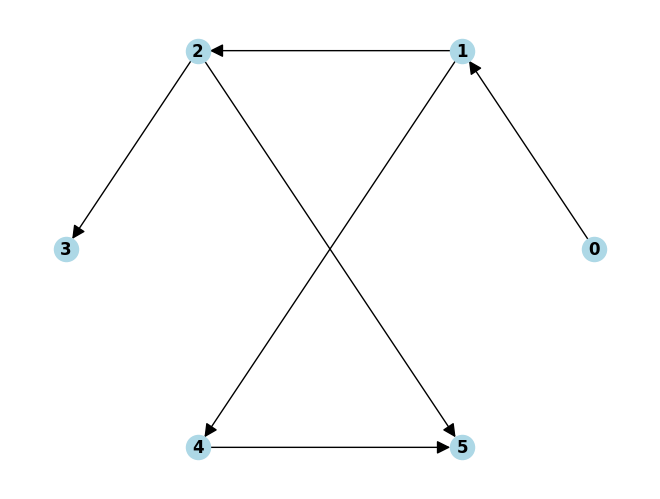

количество компонентов в смеси: 2


  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

7 11


  0%|          | 0/1000000 [00:00<?, ?it/s]

8 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

9 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

10 9


  0%|          | 0/1000000 [00:00<?, ?it/s]

11 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

12 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

13 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

14 11


  0%|          | 0/1000000 [00:00<?, ?it/s]

15 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

16 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

17 11


  0%|          | 0/1000000 [00:00<?, ?it/s]

18 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

19 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

20 11


  0%|          | 0/1000000 [00:00<?, ?it/s]

21 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

22 9


  0%|          | 0/1000000 [00:00<?, ?it/s]

23 11


  0%|          | 0/1000000 [00:00<?, ?it/s]

24 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

25 10


  0%|          | 0/1000000 [00:00<?, ?it/s]

26 13


  0%|          | 0/1000000 [00:00<?, ?it/s]

27 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

28 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

29 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

30 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

31 9


  0%|          | 0/1000000 [00:00<?, ?it/s]

32 9


  0%|          | 0/1000000 [00:00<?, ?it/s]

33 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

34 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

35 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

36 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

37 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

38 12


  0%|          | 0/1000000 [00:00<?, ?it/s]

39 10


  0%|          | 0/1000000 [00:00<?, ?it/s]

40 10


  0%|          | 0/1000000 [00:00<?, ?it/s]

41 10


  0%|          | 0/1000000 [00:00<?, ?it/s]

42 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

43 10


  0%|          | 0/1000000 [00:00<?, ?it/s]

44 11


  0%|          | 0/1000000 [00:00<?, ?it/s]

45 9


  0%|          | 0/1000000 [00:00<?, ?it/s]

46 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

47 10


  0%|          | 0/1000000 [00:00<?, ?it/s]

48 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

49 10


  0%|          | 0/1000000 [00:00<?, ?it/s]

50 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

51 11


  0%|          | 0/1000000 [00:00<?, ?it/s]

52 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

53 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

54 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

55 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

56 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

57 10


  0%|          | 0/1000000 [00:00<?, ?it/s]

58 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

59 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

60 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

61 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

62 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

63 10


  0%|          | 0/1000000 [00:00<?, ?it/s]

64 9


  0%|          | 0/1000000 [00:00<?, ?it/s]

65 9


  0%|          | 0/1000000 [00:00<?, ?it/s]

66 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

67 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

68 9


  0%|          | 0/1000000 [00:00<?, ?it/s]

69 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

70 10


  0%|          | 0/1000000 [00:00<?, ?it/s]

71 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

72 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

73 3
------------- 73 3 ------------


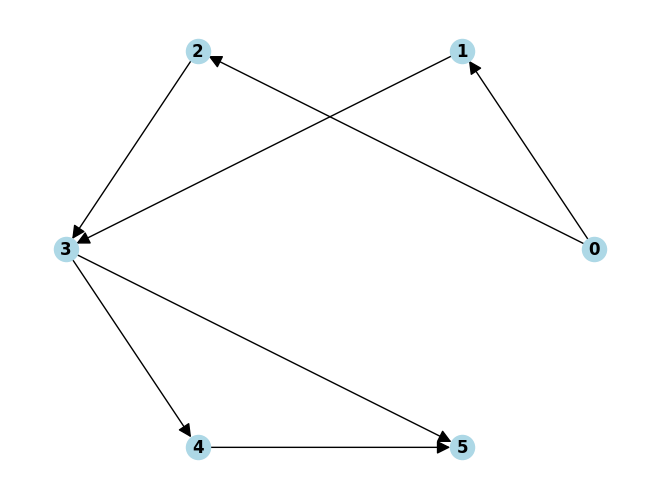

количество компонентов в смеси: 3


  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

7 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

8 11


  0%|          | 0/1000000 [00:00<?, ?it/s]

9 11


  0%|          | 0/1000000 [00:00<?, ?it/s]

10 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

11 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

12 10


  0%|          | 0/1000000 [00:00<?, ?it/s]

13 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

14 12


  0%|          | 0/1000000 [00:00<?, ?it/s]

15 11


  0%|          | 0/1000000 [00:00<?, ?it/s]

16 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

17 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

18 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

19 10


  0%|          | 0/1000000 [00:00<?, ?it/s]

20 10


  0%|          | 0/1000000 [00:00<?, ?it/s]

21 11


  0%|          | 0/1000000 [00:00<?, ?it/s]

22 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

23 11


  0%|          | 0/1000000 [00:00<?, ?it/s]

24 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

25 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

26 10


  0%|          | 0/1000000 [00:00<?, ?it/s]

27 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

28 10


  0%|          | 0/1000000 [00:00<?, ?it/s]

29 10


  0%|          | 0/1000000 [00:00<?, ?it/s]

30 12


  0%|          | 0/1000000 [00:00<?, ?it/s]

31 11


  0%|          | 0/1000000 [00:00<?, ?it/s]

32 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

33 10


  0%|          | 0/1000000 [00:00<?, ?it/s]

34 10


  0%|          | 0/1000000 [00:00<?, ?it/s]

35 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

36 11


  0%|          | 0/1000000 [00:00<?, ?it/s]

37 11


  0%|          | 0/1000000 [00:00<?, ?it/s]

38 10


  0%|          | 0/1000000 [00:00<?, ?it/s]

39 9


  0%|          | 0/1000000 [00:00<?, ?it/s]

40 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

41 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

42 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

43 12


  0%|          | 0/1000000 [00:00<?, ?it/s]

44 9


  0%|          | 0/1000000 [00:00<?, ?it/s]

45 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

46 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

47 11


  0%|          | 0/1000000 [00:00<?, ?it/s]

48 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

49 9


  0%|          | 0/1000000 [00:00<?, ?it/s]

50 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

51 9


  0%|          | 0/1000000 [00:00<?, ?it/s]

52 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

53 11


  0%|          | 0/1000000 [00:00<?, ?it/s]

54 11


  0%|          | 0/1000000 [00:00<?, ?it/s]

55 10


  0%|          | 0/1000000 [00:00<?, ?it/s]

56 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

57 11


  0%|          | 0/1000000 [00:00<?, ?it/s]

58 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

59 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

60 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

61 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

62 9


  0%|          | 0/1000000 [00:00<?, ?it/s]

63 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

64 9


  0%|          | 0/1000000 [00:00<?, ?it/s]

65 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

66 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

67 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

68 9


  0%|          | 0/1000000 [00:00<?, ?it/s]

69 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

70 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

71 10


  0%|          | 0/1000000 [00:00<?, ?it/s]

72 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

73 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

74 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

75 12


  0%|          | 0/1000000 [00:00<?, ?it/s]

76 9


  0%|          | 0/1000000 [00:00<?, ?it/s]

77 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

78 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

79 10


  0%|          | 0/1000000 [00:00<?, ?it/s]

80 10


  0%|          | 0/1000000 [00:00<?, ?it/s]

81 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

82 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

83 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

84 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

85 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

86 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

87 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

88 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

89 9


  0%|          | 0/1000000 [00:00<?, ?it/s]

90 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

91 11


  0%|          | 0/1000000 [00:00<?, ?it/s]

92 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

93 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

94 9


  0%|          | 0/1000000 [00:00<?, ?it/s]

95 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

96 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

97 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

98 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

99 9


  0%|          | 0/1000000 [00:00<?, ?it/s]

100 12


  0%|          | 0/1000000 [00:00<?, ?it/s]

101 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

102 10


  0%|          | 0/1000000 [00:00<?, ?it/s]

103 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

104 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

105 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

106 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

107 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

108 9


  0%|          | 0/1000000 [00:00<?, ?it/s]

109 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

110 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

111 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

112 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

113 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

114 11


  0%|          | 0/1000000 [00:00<?, ?it/s]

115 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

116 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

117 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

118 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

119 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

120 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

121 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

122 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

123 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

124 9


  0%|          | 0/1000000 [00:00<?, ?it/s]

125 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

126 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

127 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

128 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

129 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

130 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

131 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

132 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

133 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

134 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

135 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

136 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

137 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

138 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

139 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

140 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

141 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

142 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

143 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

144 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

145 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

146 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

147 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

148 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

149 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

150 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

151 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

152 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

153 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

154 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

155 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

156 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

157 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

158 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

159 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

160 9


  0%|          | 0/1000000 [00:00<?, ?it/s]

161 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

162 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

163 10


  0%|          | 0/1000000 [00:00<?, ?it/s]

164 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

165 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

166 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

167 10


  0%|          | 0/1000000 [00:00<?, ?it/s]

168 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

169 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

170 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

171 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

172 9


  0%|          | 0/1000000 [00:00<?, ?it/s]

173 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

174 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

175 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

176 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

177 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

178 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

179 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

180 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

181 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

182 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

183 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

184 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

185 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

186 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

187 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

188 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

189 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

190 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

191 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

192 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

193 3
------------- 193 3 ------------


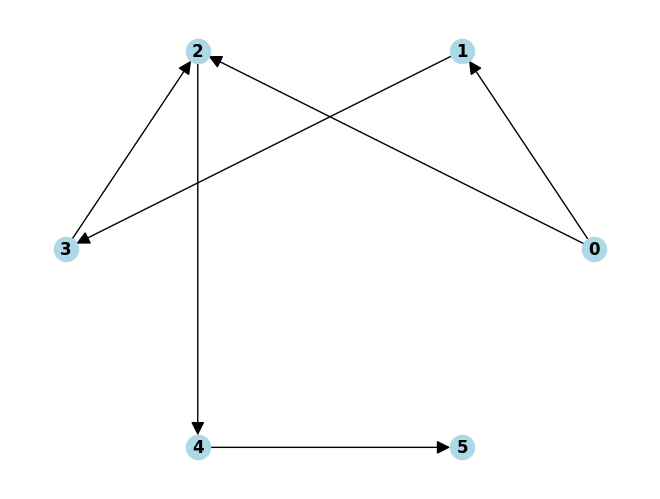

количество компонентов в смеси: 1


  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

7 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

8 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

9 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

10 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

11 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

12 10


  0%|          | 0/1000000 [00:00<?, ?it/s]

13 12


  0%|          | 0/1000000 [00:00<?, ?it/s]

14 9


  0%|          | 0/1000000 [00:00<?, ?it/s]

15 9


  0%|          | 0/1000000 [00:00<?, ?it/s]

16 10


  0%|          | 0/1000000 [00:00<?, ?it/s]

17 10


  0%|          | 0/1000000 [00:00<?, ?it/s]

18 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

19 9


  0%|          | 0/1000000 [00:00<?, ?it/s]

20 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

21 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

22 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

23 9


  0%|          | 0/1000000 [00:00<?, ?it/s]

24 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

25 9


  0%|          | 0/1000000 [00:00<?, ?it/s]

26 9


  0%|          | 0/1000000 [00:00<?, ?it/s]

27 9


  0%|          | 0/1000000 [00:00<?, ?it/s]

28 10


  0%|          | 0/1000000 [00:00<?, ?it/s]

29 9


  0%|          | 0/1000000 [00:00<?, ?it/s]

30 10


  0%|          | 0/1000000 [00:00<?, ?it/s]

31 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

32 11


  0%|          | 0/1000000 [00:00<?, ?it/s]

33 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

34 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

35 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

36 9


  0%|          | 0/1000000 [00:00<?, ?it/s]

37 10


  0%|          | 0/1000000 [00:00<?, ?it/s]

38 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

39 9


  0%|          | 0/1000000 [00:00<?, ?it/s]

40 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

41 10


  0%|          | 0/1000000 [00:00<?, ?it/s]

42 10


  0%|          | 0/1000000 [00:00<?, ?it/s]

43 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

44 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

45 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

46 9


  0%|          | 0/1000000 [00:00<?, ?it/s]

47 10


  0%|          | 0/1000000 [00:00<?, ?it/s]

48 10


  0%|          | 0/1000000 [00:00<?, ?it/s]

49 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

50 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

51 12


  0%|          | 0/1000000 [00:00<?, ?it/s]

52 11


  0%|          | 0/1000000 [00:00<?, ?it/s]

53 10


  0%|          | 0/1000000 [00:00<?, ?it/s]

54 9


  0%|          | 0/1000000 [00:00<?, ?it/s]

55 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

56 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

57 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

58 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

59 11


  0%|          | 0/1000000 [00:00<?, ?it/s]

60 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

61 11


  0%|          | 0/1000000 [00:00<?, ?it/s]

62 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

63 10


  0%|          | 0/1000000 [00:00<?, ?it/s]

64 10


  0%|          | 0/1000000 [00:00<?, ?it/s]

65 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

66 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

67 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

68 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

69 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

70 9


  0%|          | 0/1000000 [00:00<?, ?it/s]

71 10


  0%|          | 0/1000000 [00:00<?, ?it/s]

72 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

73 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

74 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

75 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

76 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

77 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

78 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

79 3
------------- 79 3 ------------


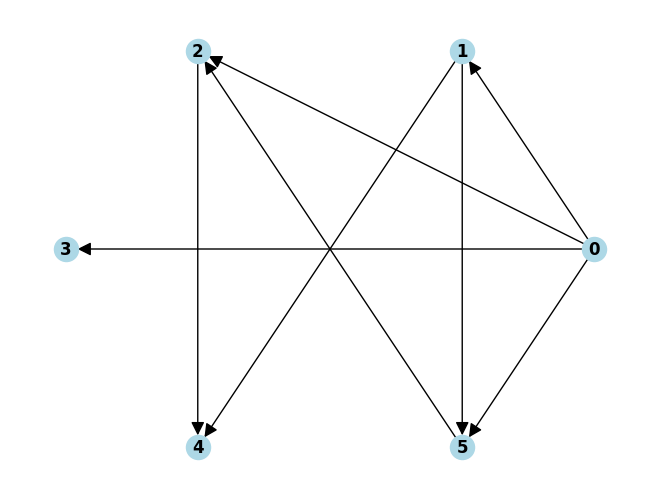

количество компонентов в смеси: 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

7 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

8 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

9 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

10 9


  0%|          | 0/1000000 [00:00<?, ?it/s]

11 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

12 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

13 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

14 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

15 11


  0%|          | 0/1000000 [00:00<?, ?it/s]

16 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

17 10


  0%|          | 0/1000000 [00:00<?, ?it/s]

18 9


  0%|          | 0/1000000 [00:00<?, ?it/s]

19 9


  0%|          | 0/1000000 [00:00<?, ?it/s]

20 9


  0%|          | 0/1000000 [00:00<?, ?it/s]

21 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

22 10


  0%|          | 0/1000000 [00:00<?, ?it/s]

23 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

24 11


  0%|          | 0/1000000 [00:00<?, ?it/s]

25 11


  0%|          | 0/1000000 [00:00<?, ?it/s]

26 11


  0%|          | 0/1000000 [00:00<?, ?it/s]

27 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

28 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

29 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

30 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

31 12


  0%|          | 0/1000000 [00:00<?, ?it/s]

32 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

33 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

34 14


  0%|          | 0/1000000 [00:00<?, ?it/s]

35 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

36 9


  0%|          | 0/1000000 [00:00<?, ?it/s]

37 13


  0%|          | 0/1000000 [00:00<?, ?it/s]

38 11


  0%|          | 0/1000000 [00:00<?, ?it/s]

39 10


  0%|          | 0/1000000 [00:00<?, ?it/s]

40 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

41 12


  0%|          | 0/1000000 [00:00<?, ?it/s]

42 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

43 10


  0%|          | 0/1000000 [00:00<?, ?it/s]

44 10


  0%|          | 0/1000000 [00:00<?, ?it/s]

45 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

46 10


  0%|          | 0/1000000 [00:00<?, ?it/s]

47 10


  0%|          | 0/1000000 [00:00<?, ?it/s]

48 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

49 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

50 10


  0%|          | 0/1000000 [00:00<?, ?it/s]

51 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

52 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

53 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

54 11


  0%|          | 0/1000000 [00:00<?, ?it/s]

55 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

56 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

57 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

58 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

59 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

60 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

61 11


  0%|          | 0/1000000 [00:00<?, ?it/s]

62 9


  0%|          | 0/1000000 [00:00<?, ?it/s]

63 11


  0%|          | 0/1000000 [00:00<?, ?it/s]

64 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

65 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

66 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

67 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

68 10


  0%|          | 0/1000000 [00:00<?, ?it/s]

69 9


  0%|          | 0/1000000 [00:00<?, ?it/s]

70 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

71 9


  0%|          | 0/1000000 [00:00<?, ?it/s]

72 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

73 10


  0%|          | 0/1000000 [00:00<?, ?it/s]

74 11


  0%|          | 0/1000000 [00:00<?, ?it/s]

75 12


  0%|          | 0/1000000 [00:00<?, ?it/s]

76 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

77 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

78 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

79 12


  0%|          | 0/1000000 [00:00<?, ?it/s]

80 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

81 10


  0%|          | 0/1000000 [00:00<?, ?it/s]

82 9


  0%|          | 0/1000000 [00:00<?, ?it/s]

83 9


  0%|          | 0/1000000 [00:00<?, ?it/s]

84 9


  0%|          | 0/1000000 [00:00<?, ?it/s]

85 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

86 11


  0%|          | 0/1000000 [00:00<?, ?it/s]

87 9


  0%|          | 0/1000000 [00:00<?, ?it/s]

88 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

89 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

90 10


  0%|          | 0/1000000 [00:00<?, ?it/s]

91 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

92 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

93 9


  0%|          | 0/1000000 [00:00<?, ?it/s]

94 10


  0%|          | 0/1000000 [00:00<?, ?it/s]

95 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

96 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

97 9


  0%|          | 0/1000000 [00:00<?, ?it/s]

98 11


  0%|          | 0/1000000 [00:00<?, ?it/s]

99 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

100 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

101 9


  0%|          | 0/1000000 [00:00<?, ?it/s]

102 11


  0%|          | 0/1000000 [00:00<?, ?it/s]

103 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

104 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

105 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

106 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

107 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

108 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

109 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

110 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

111 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

112 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

113 9


  0%|          | 0/1000000 [00:00<?, ?it/s]

114 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

115 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

116 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

117 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

118 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

119 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

120 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

121 9


  0%|          | 0/1000000 [00:00<?, ?it/s]

122 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

123 12


  0%|          | 0/1000000 [00:00<?, ?it/s]

124 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

125 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

126 10


  0%|          | 0/1000000 [00:00<?, ?it/s]

127 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

128 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

129 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

130 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

131 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

132 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

133 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

134 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

135 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

136 9


  0%|          | 0/1000000 [00:00<?, ?it/s]

137 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

138 11


  0%|          | 0/1000000 [00:00<?, ?it/s]

139 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

140 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

141 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

142 9


  0%|          | 0/1000000 [00:00<?, ?it/s]

143 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

144 9


  0%|          | 0/1000000 [00:00<?, ?it/s]

145 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

146 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

147 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

148 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

149 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

150 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

151 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

152 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

153 10


  0%|          | 0/1000000 [00:00<?, ?it/s]

154 9


  0%|          | 0/1000000 [00:00<?, ?it/s]

155 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

156 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

157 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

158 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

159 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

160 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

161 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

162 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

163 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

164 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

165 3
------------- 165 3 ------------


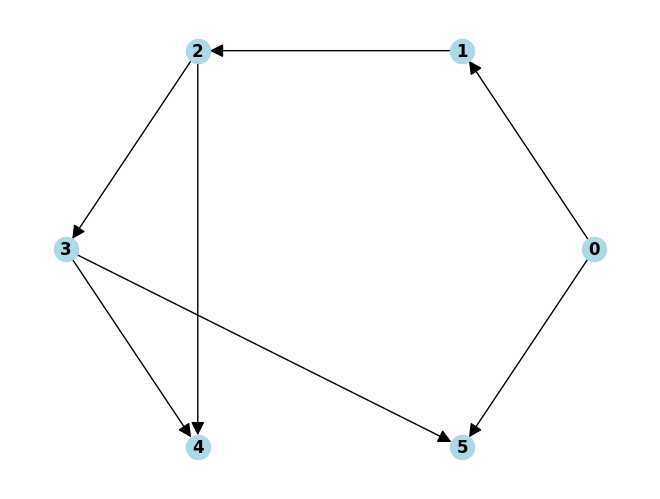

количество компонентов в смеси: 3


  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

7 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

8 9


  0%|          | 0/1000000 [00:00<?, ?it/s]

9 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

10 11


  0%|          | 0/1000000 [00:00<?, ?it/s]

11 9


  0%|          | 0/1000000 [00:00<?, ?it/s]

12 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

13 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

14 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

15 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

16 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

17 11


  0%|          | 0/1000000 [00:00<?, ?it/s]

18 10


  0%|          | 0/1000000 [00:00<?, ?it/s]

19 9


  0%|          | 0/1000000 [00:00<?, ?it/s]

20 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

21 9


  0%|          | 0/1000000 [00:00<?, ?it/s]

22 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

23 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

24 10


  0%|          | 0/1000000 [00:00<?, ?it/s]

25 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

26 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

27 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

28 12


  0%|          | 0/1000000 [00:00<?, ?it/s]

29 11


  0%|          | 0/1000000 [00:00<?, ?it/s]

30 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

31 9


  0%|          | 0/1000000 [00:00<?, ?it/s]

32 9


  0%|          | 0/1000000 [00:00<?, ?it/s]

33 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

34 9


  0%|          | 0/1000000 [00:00<?, ?it/s]

35 9


  0%|          | 0/1000000 [00:00<?, ?it/s]

36 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

37 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

38 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

39 9


  0%|          | 0/1000000 [00:00<?, ?it/s]

40 10


  0%|          | 0/1000000 [00:00<?, ?it/s]

41 10


  0%|          | 0/1000000 [00:00<?, ?it/s]

42 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

43 11


  0%|          | 0/1000000 [00:00<?, ?it/s]

44 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

45 9


  0%|          | 0/1000000 [00:00<?, ?it/s]

46 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

47 10


  0%|          | 0/1000000 [00:00<?, ?it/s]

48 10


  0%|          | 0/1000000 [00:00<?, ?it/s]

49 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

50 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

51 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

52 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

53 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

54 10


  0%|          | 0/1000000 [00:00<?, ?it/s]

55 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

56 10


  0%|          | 0/1000000 [00:00<?, ?it/s]

57 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

58 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

59 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

60 10


  0%|          | 0/1000000 [00:00<?, ?it/s]

61 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

62 10


  0%|          | 0/1000000 [00:00<?, ?it/s]

63 9


  0%|          | 0/1000000 [00:00<?, ?it/s]

64 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

65 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

66 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

67 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

68 9


  0%|          | 0/1000000 [00:00<?, ?it/s]

69 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

70 9


  0%|          | 0/1000000 [00:00<?, ?it/s]

71 9


  0%|          | 0/1000000 [00:00<?, ?it/s]

72 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

73 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

74 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

75 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

76 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

77 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

78 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

79 10


  0%|          | 0/1000000 [00:00<?, ?it/s]

80 9


  0%|          | 0/1000000 [00:00<?, ?it/s]

81 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

82 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

83 11


  0%|          | 0/1000000 [00:00<?, ?it/s]

84 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

85 9


  0%|          | 0/1000000 [00:00<?, ?it/s]

86 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

87 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

88 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

89 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

90 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

91 9


  0%|          | 0/1000000 [00:00<?, ?it/s]

92 10


  0%|          | 0/1000000 [00:00<?, ?it/s]

93 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

94 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

95 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

96 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

97 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

98 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

99 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

100 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

101 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

102 9


  0%|          | 0/1000000 [00:00<?, ?it/s]

103 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

104 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

105 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

106 3
------------- 106 3 ------------


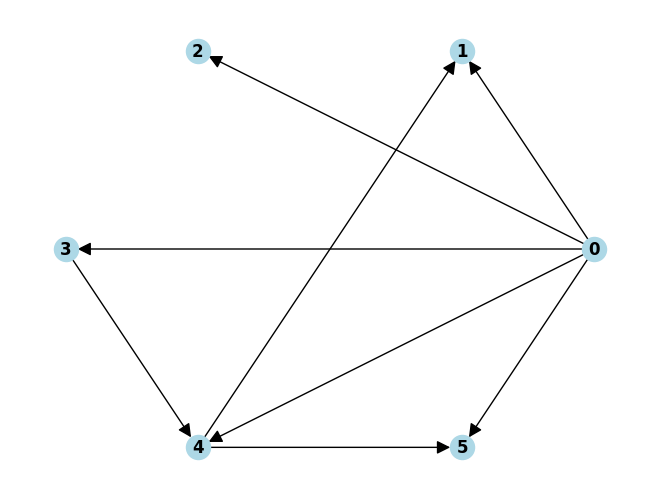

количество компонентов в смеси: 3


  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

7 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

8 9


  0%|          | 0/1000000 [00:00<?, ?it/s]

9 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

10 12


  0%|          | 0/1000000 [00:00<?, ?it/s]

11 10


  0%|          | 0/1000000 [00:00<?, ?it/s]

12 11


  0%|          | 0/1000000 [00:00<?, ?it/s]

13 11


  0%|          | 0/1000000 [00:00<?, ?it/s]

14 10


  0%|          | 0/1000000 [00:00<?, ?it/s]

15 9


  0%|          | 0/1000000 [00:00<?, ?it/s]

16 10


  0%|          | 0/1000000 [00:00<?, ?it/s]

17 10


  0%|          | 0/1000000 [00:00<?, ?it/s]

18 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

19 13


  0%|          | 0/1000000 [00:00<?, ?it/s]

20 9


  0%|          | 0/1000000 [00:00<?, ?it/s]

21 9


  0%|          | 0/1000000 [00:00<?, ?it/s]

22 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

23 9


  0%|          | 0/1000000 [00:00<?, ?it/s]

24 11


  0%|          | 0/1000000 [00:00<?, ?it/s]

25 9


  0%|          | 0/1000000 [00:00<?, ?it/s]

26 9


  0%|          | 0/1000000 [00:00<?, ?it/s]

27 10


  0%|          | 0/1000000 [00:00<?, ?it/s]

28 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

29 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

30 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

31 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

32 9


  0%|          | 0/1000000 [00:00<?, ?it/s]

33 14


  0%|          | 0/1000000 [00:00<?, ?it/s]

34 10


  0%|          | 0/1000000 [00:00<?, ?it/s]

35 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

36 11


  0%|          | 0/1000000 [00:00<?, ?it/s]

37 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

38 10


  0%|          | 0/1000000 [00:00<?, ?it/s]

39 12


  0%|          | 0/1000000 [00:00<?, ?it/s]

40 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

41 10


  0%|          | 0/1000000 [00:00<?, ?it/s]

42 9


  0%|          | 0/1000000 [00:00<?, ?it/s]

43 9


  0%|          | 0/1000000 [00:00<?, ?it/s]

44 9


  0%|          | 0/1000000 [00:00<?, ?it/s]

45 10


  0%|          | 0/1000000 [00:00<?, ?it/s]

46 10


  0%|          | 0/1000000 [00:00<?, ?it/s]

47 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

48 11


  0%|          | 0/1000000 [00:00<?, ?it/s]

49 9


  0%|          | 0/1000000 [00:00<?, ?it/s]

50 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

51 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

52 9


  0%|          | 0/1000000 [00:00<?, ?it/s]

53 11


  0%|          | 0/1000000 [00:00<?, ?it/s]

54 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

55 11


  0%|          | 0/1000000 [00:00<?, ?it/s]

56 9


  0%|          | 0/1000000 [00:00<?, ?it/s]

57 9


  0%|          | 0/1000000 [00:00<?, ?it/s]

58 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

59 9


  0%|          | 0/1000000 [00:00<?, ?it/s]

60 12


  0%|          | 0/1000000 [00:00<?, ?it/s]

61 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

62 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

63 9


  0%|          | 0/1000000 [00:00<?, ?it/s]

64 12


  0%|          | 0/1000000 [00:00<?, ?it/s]

65 10


  0%|          | 0/1000000 [00:00<?, ?it/s]

66 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

67 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

68 10


  0%|          | 0/1000000 [00:00<?, ?it/s]

69 9


  0%|          | 0/1000000 [00:00<?, ?it/s]

70 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

71 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

72 10


  0%|          | 0/1000000 [00:00<?, ?it/s]

73 9


  0%|          | 0/1000000 [00:00<?, ?it/s]

74 9


  0%|          | 0/1000000 [00:00<?, ?it/s]

75 10


  0%|          | 0/1000000 [00:00<?, ?it/s]

76 10


  0%|          | 0/1000000 [00:00<?, ?it/s]

77 10


  0%|          | 0/1000000 [00:00<?, ?it/s]

78 11


  0%|          | 0/1000000 [00:00<?, ?it/s]

79 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

80 9


  0%|          | 0/1000000 [00:00<?, ?it/s]

81 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

82 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

83 12


  0%|          | 0/1000000 [00:00<?, ?it/s]

84 9


  0%|          | 0/1000000 [00:00<?, ?it/s]

85 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

86 10


  0%|          | 0/1000000 [00:00<?, ?it/s]

87 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

88 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

89 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

90 10


  0%|          | 0/1000000 [00:00<?, ?it/s]

91 13


  0%|          | 0/1000000 [00:00<?, ?it/s]

92 11


  0%|          | 0/1000000 [00:00<?, ?it/s]

93 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

94 10


  0%|          | 0/1000000 [00:00<?, ?it/s]

95 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

96 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

97 9


  0%|          | 0/1000000 [00:00<?, ?it/s]

98 10


  0%|          | 0/1000000 [00:00<?, ?it/s]

99 11


  0%|          | 0/1000000 [00:00<?, ?it/s]

100 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

101 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

102 9


  0%|          | 0/1000000 [00:00<?, ?it/s]

103 9


  0%|          | 0/1000000 [00:00<?, ?it/s]

104 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

105 12


  0%|          | 0/1000000 [00:00<?, ?it/s]

106 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

107 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

108 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

109 9


  0%|          | 0/1000000 [00:00<?, ?it/s]

110 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

111 9


  0%|          | 0/1000000 [00:00<?, ?it/s]

112 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

113 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

114 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

115 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

116 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

117 10


  0%|          | 0/1000000 [00:00<?, ?it/s]

118 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

119 10


  0%|          | 0/1000000 [00:00<?, ?it/s]

120 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

121 9


  0%|          | 0/1000000 [00:00<?, ?it/s]

122 9


  0%|          | 0/1000000 [00:00<?, ?it/s]

123 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

124 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

125 10


  0%|          | 0/1000000 [00:00<?, ?it/s]

126 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

127 11


  0%|          | 0/1000000 [00:00<?, ?it/s]

128 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

129 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

130 9


  0%|          | 0/1000000 [00:00<?, ?it/s]

131 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

132 10


  0%|          | 0/1000000 [00:00<?, ?it/s]

133 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

134 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

135 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

136 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

137 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

138 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

139 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

140 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

141 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

142 9


  0%|          | 0/1000000 [00:00<?, ?it/s]

143 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

144 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

145 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

146 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

147 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

148 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

149 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

150 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

151 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

152 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

153 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

154 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

155 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

156 9


  0%|          | 0/1000000 [00:00<?, ?it/s]

157 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

158 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

159 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

160 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

161 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

162 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

163 9


  0%|          | 0/1000000 [00:00<?, ?it/s]

164 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

165 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

166 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

167 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

168 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

169 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

170 9


  0%|          | 0/1000000 [00:00<?, ?it/s]

171 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

172 9


  0%|          | 0/1000000 [00:00<?, ?it/s]

173 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

174 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

175 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

176 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

177 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

178 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

179 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

180 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

181 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

182 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

183 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

184 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

185 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

186 10


  0%|          | 0/1000000 [00:00<?, ?it/s]

187 9


  0%|          | 0/1000000 [00:00<?, ?it/s]

188 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

189 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

190 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

191 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

192 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

193 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

194 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

195 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

196 9


  0%|          | 0/1000000 [00:00<?, ?it/s]

197 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

198 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

199 10


  0%|          | 0/1000000 [00:00<?, ?it/s]

200 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

201 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

202 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

203 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

204 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

205 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

206 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

207 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

208 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

209 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

210 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

211 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

212 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

213 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

214 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

215 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

216 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

217 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

218 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

219 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

220 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

221 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

222 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

223 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

224 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

225 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

226 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

227 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

228 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

229 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

230 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

231 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

232 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

233 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

234 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

235 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

236 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

237 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

238 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

239 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

240 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

241 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

242 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

243 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

244 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

245 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

246 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

247 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

248 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

249 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

250 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

251 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

252 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

253 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

254 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

255 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

256 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

257 9


  0%|          | 0/1000000 [00:00<?, ?it/s]

258 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

259 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

260 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

261 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

262 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

263 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

264 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

265 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

266 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

267 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

268 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

269 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

270 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

271 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

272 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

273 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

274 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

275 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

276 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

277 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

278 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

279 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

280 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

281 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

282 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

283 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

284 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

285 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

286 9


  0%|          | 0/1000000 [00:00<?, ?it/s]

287 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

288 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

289 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

290 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

291 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

292 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

293 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

294 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

295 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

296 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

297 9


  0%|          | 0/1000000 [00:00<?, ?it/s]

298 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

299 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

300 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

301 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

302 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

303 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

304 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

305 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

306 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

307 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

308 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

309 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

310 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

311 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

312 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

313 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

314 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

315 9


  0%|          | 0/1000000 [00:00<?, ?it/s]

316 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

317 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

318 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

319 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

320 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

321 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

322 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

323 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

324 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

325 9


  0%|          | 0/1000000 [00:00<?, ?it/s]

326 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

327 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

328 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

329 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

330 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

331 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

332 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

333 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

334 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

335 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

336 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

337 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

338 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

339 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

340 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

341 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

342 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

343 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

344 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

345 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

346 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

347 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

348 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

349 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

350 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

351 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

352 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

353 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

354 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

355 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

356 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

357 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

358 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

359 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

360 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

361 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

362 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

363 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

364 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

365 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

366 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

367 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

368 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

369 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

370 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

371 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

372 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

373 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

374 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

375 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

376 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

377 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

378 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

379 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

380 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

381 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

382 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

383 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

384 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

385 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

386 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

387 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

388 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

389 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

390 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

391 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

392 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

393 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

394 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

395 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

396 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

397 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

398 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

399 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

400 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

401 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

402 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

403 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

404 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

405 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

406 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

407 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

408 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

409 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

410 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

411 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

412 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

413 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

414 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

415 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

416 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

417 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

418 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

419 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

420 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

421 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

422 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

423 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

424 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

425 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

426 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

427 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

428 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

429 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

430 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

431 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

432 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

433 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

434 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

435 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

436 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

437 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

438 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

439 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

440 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

441 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

442 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

443 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

444 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

445 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

446 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

447 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

448 9


  0%|          | 0/1000000 [00:00<?, ?it/s]

449 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

450 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

451 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

452 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

453 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

454 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

455 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

456 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

457 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

458 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

459 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

460 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

461 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

462 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

463 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

464 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

465 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

466 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

467 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

468 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

469 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

470 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

471 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

472 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

473 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

474 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

475 9


  0%|          | 0/1000000 [00:00<?, ?it/s]

476 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

477 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

478 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

479 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

480 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

481 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

482 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

483 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

484 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

485 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

486 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

487 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

488 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

489 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

490 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

491 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

492 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

493 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

494 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

495 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

496 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

497 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

498 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

499 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

500 9


  0%|          | 0/1000000 [00:00<?, ?it/s]

501 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

502 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

503 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

504 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

505 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

506 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

507 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

508 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

509 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

510 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

511 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

512 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

513 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

514 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

515 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

516 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

517 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

518 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

519 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

520 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

521 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

522 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

523 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

524 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

525 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

526 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

527 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

528 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

529 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

530 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

531 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

532 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

533 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

534 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

535 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

536 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

537 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

538 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

539 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

540 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

541 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

542 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

543 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

544 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

545 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

546 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

547 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

548 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

549 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

550 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

551 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

552 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

553 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

554 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

555 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

556 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

557 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

558 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

559 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

560 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

561 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

562 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

563 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

564 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

565 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

566 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

567 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

568 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

569 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

570 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

571 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

572 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

573 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

574 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

575 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

576 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

577 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

578 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

579 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

580 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

581 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

582 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

583 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

584 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

585 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

586 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

587 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

588 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

589 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

590 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

591 9


  0%|          | 0/1000000 [00:00<?, ?it/s]

592 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

593 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

594 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

595 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

596 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

597 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

598 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

599 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

600 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

601 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

602 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

603 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

604 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

605 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

606 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

607 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

608 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

609 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

610 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

611 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

612 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

613 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

614 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

615 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

616 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

617 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

618 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

619 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

620 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

621 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

622 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

623 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

624 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

625 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

626 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

627 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

628 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

629 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

630 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

631 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

632 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

633 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

634 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

635 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

636 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

637 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

638 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

639 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

640 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

641 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

642 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

643 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

644 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

645 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

646 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

647 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

648 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

649 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

650 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

651 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

652 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

653 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

654 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

655 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

656 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

657 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

658 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

659 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

660 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

661 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

662 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

663 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

664 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

665 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

666 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

667 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

668 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

669 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

670 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

671 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

672 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

673 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

674 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

675 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

676 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

677 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

678 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

679 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

680 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

681 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

682 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

683 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

684 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

685 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

686 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

687 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

688 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

689 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

690 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

691 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

692 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

693 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

694 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

695 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

696 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

697 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

698 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

699 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

700 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

701 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

702 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

703 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

704 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

705 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

706 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

707 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

708 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

709 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

710 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

711 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

712 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

713 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

714 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

715 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

716 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

717 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

718 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

719 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

720 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

721 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

722 9


  0%|          | 0/1000000 [00:00<?, ?it/s]

723 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

724 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

725 9


  0%|          | 0/1000000 [00:00<?, ?it/s]

726 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

727 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

728 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

729 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

730 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

731 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

732 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

733 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

734 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

735 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

736 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

737 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

738 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

739 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

740 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

741 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

742 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

743 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

744 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

745 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

746 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

747 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

748 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

749 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

750 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

751 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

752 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

753 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

754 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

755 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

756 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

757 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

758 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

759 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

760 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

761 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

762 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

763 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

764 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

765 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

766 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

767 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

768 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

769 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

770 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

771 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

772 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

773 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

774 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

775 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

776 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

777 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

778 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

779 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

780 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

781 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

782 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

783 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

784 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

785 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

786 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

787 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

788 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

789 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

790 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

791 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

792 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

793 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

794 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

795 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

796 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

797 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

798 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

799 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

800 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

801 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

802 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

803 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

804 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

805 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

806 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

807 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

808 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

809 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

810 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

811 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

812 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

813 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

814 3
------------- 814 3 ------------


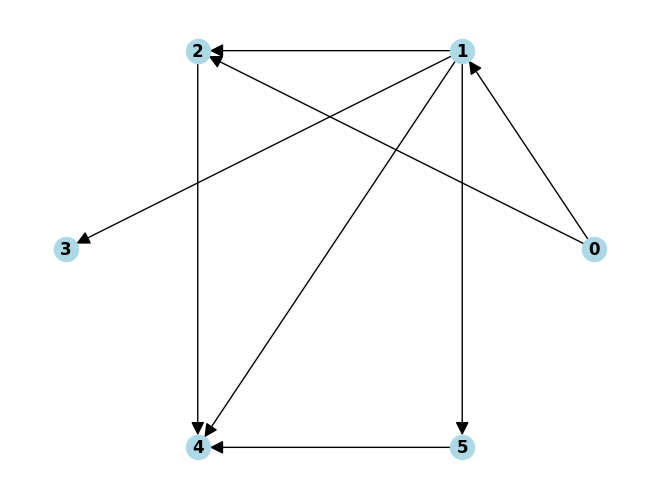

количество компонентов в смеси: 3


  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

7 11


  0%|          | 0/1000000 [00:00<?, ?it/s]

8 11


  0%|          | 0/1000000 [00:00<?, ?it/s]

9 12


  0%|          | 0/1000000 [00:00<?, ?it/s]

10 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

11 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

12 9


  0%|          | 0/1000000 [00:00<?, ?it/s]

13 10


  0%|          | 0/1000000 [00:00<?, ?it/s]

14 11


  0%|          | 0/1000000 [00:00<?, ?it/s]

15 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

16 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

17 10


  0%|          | 0/1000000 [00:00<?, ?it/s]

18 9


  0%|          | 0/1000000 [00:00<?, ?it/s]

19 10


  0%|          | 0/1000000 [00:00<?, ?it/s]

20 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

21 10


  0%|          | 0/1000000 [00:00<?, ?it/s]

22 9


  0%|          | 0/1000000 [00:00<?, ?it/s]

23 9


  0%|          | 0/1000000 [00:00<?, ?it/s]

24 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

25 9


  0%|          | 0/1000000 [00:00<?, ?it/s]

26 10


  0%|          | 0/1000000 [00:00<?, ?it/s]

27 10


  0%|          | 0/1000000 [00:00<?, ?it/s]

28 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

29 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

30 9


  0%|          | 0/1000000 [00:00<?, ?it/s]

31 9


  0%|          | 0/1000000 [00:00<?, ?it/s]

32 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

33 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

34 10


  0%|          | 0/1000000 [00:00<?, ?it/s]

35 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

36 9


  0%|          | 0/1000000 [00:00<?, ?it/s]

37 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

38 9


  0%|          | 0/1000000 [00:00<?, ?it/s]

39 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

40 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

41 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

42 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

43 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

44 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

45 11


  0%|          | 0/1000000 [00:00<?, ?it/s]

46 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

47 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

48 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

49 12


  0%|          | 0/1000000 [00:00<?, ?it/s]

50 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

51 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

52 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

53 12


  0%|          | 0/1000000 [00:00<?, ?it/s]

54 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

55 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

56 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

57 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

58 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

59 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

60 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

61 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

62 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

63 3
------------- 63 3 ------------


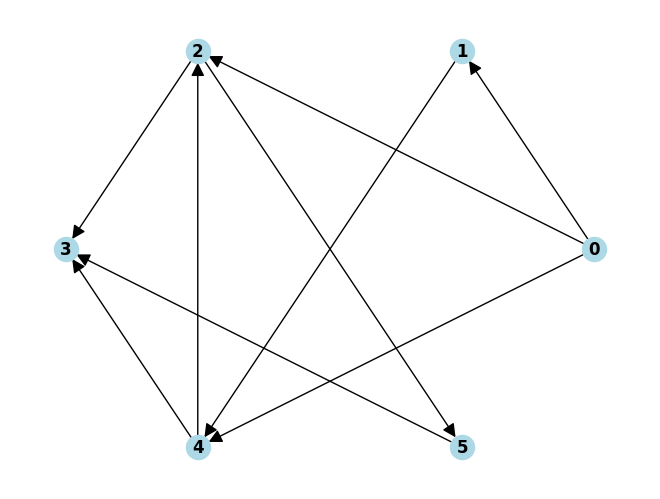

количество компонентов в смеси: 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

7 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

8 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

9 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

10 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

11 9


  0%|          | 0/1000000 [00:00<?, ?it/s]

12 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

13 12


  0%|          | 0/1000000 [00:00<?, ?it/s]

14 11


  0%|          | 0/1000000 [00:00<?, ?it/s]

15 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

16 11


  0%|          | 0/1000000 [00:00<?, ?it/s]

17 12


  0%|          | 0/1000000 [00:00<?, ?it/s]

18 11


  0%|          | 0/1000000 [00:00<?, ?it/s]

19 10


  0%|          | 0/1000000 [00:00<?, ?it/s]

20 10


  0%|          | 0/1000000 [00:00<?, ?it/s]

21 9


  0%|          | 0/1000000 [00:00<?, ?it/s]

22 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

23 10


  0%|          | 0/1000000 [00:00<?, ?it/s]

24 10


  0%|          | 0/1000000 [00:00<?, ?it/s]

25 10


  0%|          | 0/1000000 [00:00<?, ?it/s]

26 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

27 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

28 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

29 12


  0%|          | 0/1000000 [00:00<?, ?it/s]

30 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

31 11


  0%|          | 0/1000000 [00:00<?, ?it/s]

32 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

33 10


  0%|          | 0/1000000 [00:00<?, ?it/s]

34 11


  0%|          | 0/1000000 [00:00<?, ?it/s]

35 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

36 12


  0%|          | 0/1000000 [00:00<?, ?it/s]

37 11


  0%|          | 0/1000000 [00:00<?, ?it/s]

38 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

39 9


  0%|          | 0/1000000 [00:00<?, ?it/s]

40 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

41 11


  0%|          | 0/1000000 [00:00<?, ?it/s]

42 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

43 10


  0%|          | 0/1000000 [00:00<?, ?it/s]

44 9


  0%|          | 0/1000000 [00:00<?, ?it/s]

45 9


  0%|          | 0/1000000 [00:00<?, ?it/s]

46 12


  0%|          | 0/1000000 [00:00<?, ?it/s]

47 12


  0%|          | 0/1000000 [00:00<?, ?it/s]

48 10


  0%|          | 0/1000000 [00:00<?, ?it/s]

49 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

50 11


  0%|          | 0/1000000 [00:00<?, ?it/s]

51 11


  0%|          | 0/1000000 [00:00<?, ?it/s]

52 10


  0%|          | 0/1000000 [00:00<?, ?it/s]

53 9


  0%|          | 0/1000000 [00:00<?, ?it/s]

54 9


  0%|          | 0/1000000 [00:00<?, ?it/s]

55 12


  0%|          | 0/1000000 [00:00<?, ?it/s]

56 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

57 10


  0%|          | 0/1000000 [00:00<?, ?it/s]

58 10


  0%|          | 0/1000000 [00:00<?, ?it/s]

59 11


  0%|          | 0/1000000 [00:00<?, ?it/s]

60 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

61 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

62 10


  0%|          | 0/1000000 [00:00<?, ?it/s]

63 9


  0%|          | 0/1000000 [00:00<?, ?it/s]

64 10


  0%|          | 0/1000000 [00:00<?, ?it/s]

65 11


  0%|          | 0/1000000 [00:00<?, ?it/s]

66 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

67 11


  0%|          | 0/1000000 [00:00<?, ?it/s]

68 10


  0%|          | 0/1000000 [00:00<?, ?it/s]

69 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

70 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

71 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

72 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

73 11


  0%|          | 0/1000000 [00:00<?, ?it/s]

74 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

75 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

76 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

77 9


  0%|          | 0/1000000 [00:00<?, ?it/s]

78 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

79 9


  0%|          | 0/1000000 [00:00<?, ?it/s]

80 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

81 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

82 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

83 10


  0%|          | 0/1000000 [00:00<?, ?it/s]

84 11


  0%|          | 0/1000000 [00:00<?, ?it/s]

85 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

86 11


  0%|          | 0/1000000 [00:00<?, ?it/s]

87 9


  0%|          | 0/1000000 [00:00<?, ?it/s]

88 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

89 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

90 9


  0%|          | 0/1000000 [00:00<?, ?it/s]

91 9


  0%|          | 0/1000000 [00:00<?, ?it/s]

92 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

93 9


  0%|          | 0/1000000 [00:00<?, ?it/s]

94 9


  0%|          | 0/1000000 [00:00<?, ?it/s]

95 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

96 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

97 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

98 9


  0%|          | 0/1000000 [00:00<?, ?it/s]

99 9


  0%|          | 0/1000000 [00:00<?, ?it/s]

100 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

101 9


  0%|          | 0/1000000 [00:00<?, ?it/s]

102 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

103 11


  0%|          | 0/1000000 [00:00<?, ?it/s]

104 10


  0%|          | 0/1000000 [00:00<?, ?it/s]

105 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

106 12


  0%|          | 0/1000000 [00:00<?, ?it/s]

107 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

108 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

109 11


  0%|          | 0/1000000 [00:00<?, ?it/s]

110 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

111 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

112 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

113 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

114 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

115 9


  0%|          | 0/1000000 [00:00<?, ?it/s]

116 9


  0%|          | 0/1000000 [00:00<?, ?it/s]

117 9


  0%|          | 0/1000000 [00:00<?, ?it/s]

118 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

119 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

120 9


  0%|          | 0/1000000 [00:00<?, ?it/s]

121 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

122 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

123 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

124 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

125 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

126 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

127 10


  0%|          | 0/1000000 [00:00<?, ?it/s]

128 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

129 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

130 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

131 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

132 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

133 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

134 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

135 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

136 9


  0%|          | 0/1000000 [00:00<?, ?it/s]

137 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

138 11


  0%|          | 0/1000000 [00:00<?, ?it/s]

139 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

140 10


  0%|          | 0/1000000 [00:00<?, ?it/s]

141 9


  0%|          | 0/1000000 [00:00<?, ?it/s]

142 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

143 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

144 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

145 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

146 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

147 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

148 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

149 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

150 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

151 9


  0%|          | 0/1000000 [00:00<?, ?it/s]

152 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

153 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

154 10


  0%|          | 0/1000000 [00:00<?, ?it/s]

155 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

156 9


  0%|          | 0/1000000 [00:00<?, ?it/s]

157 9


  0%|          | 0/1000000 [00:00<?, ?it/s]

158 10


  0%|          | 0/1000000 [00:00<?, ?it/s]

159 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

160 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

161 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

162 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

163 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

164 10


  0%|          | 0/1000000 [00:00<?, ?it/s]

165 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

166 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

167 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

168 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

169 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

170 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

171 10


  0%|          | 0/1000000 [00:00<?, ?it/s]

172 9


  0%|          | 0/1000000 [00:00<?, ?it/s]

173 9


  0%|          | 0/1000000 [00:00<?, ?it/s]

174 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

175 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

176 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

177 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

178 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

179 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

180 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

181 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

182 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

183 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

184 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

185 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

186 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

187 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

188 9


  0%|          | 0/1000000 [00:00<?, ?it/s]

189 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

190 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

191 9


  0%|          | 0/1000000 [00:00<?, ?it/s]

192 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

193 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

194 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

195 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

196 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

197 9


  0%|          | 0/1000000 [00:00<?, ?it/s]

198 11


  0%|          | 0/1000000 [00:00<?, ?it/s]

199 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

200 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

201 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

202 9


  0%|          | 0/1000000 [00:00<?, ?it/s]

203 9


  0%|          | 0/1000000 [00:00<?, ?it/s]

204 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

205 9


  0%|          | 0/1000000 [00:00<?, ?it/s]

206 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

207 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

208 11


  0%|          | 0/1000000 [00:00<?, ?it/s]

209 9


  0%|          | 0/1000000 [00:00<?, ?it/s]

210 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

211 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

212 9


  0%|          | 0/1000000 [00:00<?, ?it/s]

213 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

214 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

215 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

216 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

217 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

218 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

219 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

220 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

221 9


  0%|          | 0/1000000 [00:00<?, ?it/s]

222 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

223 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

224 9


  0%|          | 0/1000000 [00:00<?, ?it/s]

225 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

226 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

227 9


  0%|          | 0/1000000 [00:00<?, ?it/s]

228 10


  0%|          | 0/1000000 [00:00<?, ?it/s]

229 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

230 9


  0%|          | 0/1000000 [00:00<?, ?it/s]

231 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

232 9


  0%|          | 0/1000000 [00:00<?, ?it/s]

233 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

234 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

235 10


  0%|          | 0/1000000 [00:00<?, ?it/s]

236 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

237 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

238 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

239 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

240 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

241 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

242 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

243 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

244 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

245 9


  0%|          | 0/1000000 [00:00<?, ?it/s]

246 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

247 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

248 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

249 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

250 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

251 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

252 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

253 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

254 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

255 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

256 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

257 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

258 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

259 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

260 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

261 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

262 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

263 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

264 9


  0%|          | 0/1000000 [00:00<?, ?it/s]

265 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

266 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

267 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

268 10


  0%|          | 0/1000000 [00:00<?, ?it/s]

269 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

270 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

271 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

272 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

273 9


  0%|          | 0/1000000 [00:00<?, ?it/s]

274 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

275 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

276 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

277 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

278 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

279 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

280 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

281 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

282 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

283 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

284 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

285 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

286 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

287 9


  0%|          | 0/1000000 [00:00<?, ?it/s]

288 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

289 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

290 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

291 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

292 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

293 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

294 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

295 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

296 9


  0%|          | 0/1000000 [00:00<?, ?it/s]

297 11


  0%|          | 0/1000000 [00:00<?, ?it/s]

298 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

299 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

300 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

301 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

302 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

303 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

304 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

305 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

306 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

307 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

308 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

309 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

310 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

311 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

312 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

313 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

314 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

315 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

316 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

317 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

318 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

319 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

320 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

321 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

322 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

323 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

324 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

325 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

326 9


  0%|          | 0/1000000 [00:00<?, ?it/s]

327 9


  0%|          | 0/1000000 [00:00<?, ?it/s]

328 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

329 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

330 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

331 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

332 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

333 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

334 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

335 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

336 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

337 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

338 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

339 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

340 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

341 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

342 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

343 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

344 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

345 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

346 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

347 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

348 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

349 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

350 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

351 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

352 9


  0%|          | 0/1000000 [00:00<?, ?it/s]

353 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

354 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

355 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

356 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

357 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

358 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

359 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

360 9


  0%|          | 0/1000000 [00:00<?, ?it/s]

361 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

362 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

363 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

364 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

365 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

366 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

367 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

368 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

369 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

370 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

371 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

372 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

373 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

374 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

375 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

376 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

377 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

378 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

379 9


  0%|          | 0/1000000 [00:00<?, ?it/s]

380 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

381 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

382 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

383 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

384 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

385 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

386 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

387 9


  0%|          | 0/1000000 [00:00<?, ?it/s]

388 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

389 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

390 9


  0%|          | 0/1000000 [00:00<?, ?it/s]

391 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

392 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

393 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

394 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

395 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

396 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

397 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

398 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

399 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

400 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

401 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

402 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

403 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

404 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

405 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

406 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

407 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

408 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

409 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

410 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

411 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

412 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

413 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

414 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

415 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

416 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

417 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

418 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

419 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

420 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

421 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

422 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

423 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

424 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

425 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

426 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

427 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

428 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

429 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

430 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

431 9


  0%|          | 0/1000000 [00:00<?, ?it/s]

432 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

433 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

434 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

435 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

436 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

437 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

438 9


  0%|          | 0/1000000 [00:00<?, ?it/s]

439 9


  0%|          | 0/1000000 [00:00<?, ?it/s]

440 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

441 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

442 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

443 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

444 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

445 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

446 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

447 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

448 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

449 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

450 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

451 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

452 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

453 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

454 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

455 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

456 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

457 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

458 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

459 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

460 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

461 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

462 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

463 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

464 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

465 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

466 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

467 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

468 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

469 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

470 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

471 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

472 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

473 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

474 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

475 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

476 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

477 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

478 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

479 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

480 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

481 9


  0%|          | 0/1000000 [00:00<?, ?it/s]

482 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

483 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

484 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

485 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

486 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

487 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

488 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

489 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

490 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

491 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

492 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

493 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

494 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

495 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

496 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

497 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

498 9


  0%|          | 0/1000000 [00:00<?, ?it/s]

499 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

500 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

501 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

502 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

503 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

504 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

505 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

506 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

507 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

508 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

509 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

510 9


  0%|          | 0/1000000 [00:00<?, ?it/s]

511 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

512 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

513 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

514 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

515 9


  0%|          | 0/1000000 [00:00<?, ?it/s]

516 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

517 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

518 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

519 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

520 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

521 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

522 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

523 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

524 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

525 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

526 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

527 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

528 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

529 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

530 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

531 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

532 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

533 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

534 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

535 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

536 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

537 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

538 9


  0%|          | 0/1000000 [00:00<?, ?it/s]

539 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

540 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

541 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

542 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

543 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

544 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

545 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

546 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

547 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

548 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

549 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

550 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

551 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

552 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

553 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

554 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

555 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

556 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

557 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

558 9


  0%|          | 0/1000000 [00:00<?, ?it/s]

559 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

560 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

561 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

562 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

563 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

564 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

565 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

566 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

567 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

568 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

569 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

570 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

571 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

572 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

573 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

574 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

575 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

576 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

577 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

578 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

579 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

580 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

581 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

582 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

583 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

584 9


  0%|          | 0/1000000 [00:00<?, ?it/s]

585 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

586 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

587 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

588 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

589 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

590 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

591 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

592 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

593 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

594 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

595 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

596 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

597 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

598 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

599 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

600 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

601 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

602 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

603 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

604 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

605 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

606 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

607 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

608 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

609 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

610 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

611 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

612 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

613 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

614 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

615 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

616 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

617 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

618 9


  0%|          | 0/1000000 [00:00<?, ?it/s]

619 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

620 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

621 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

622 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

623 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

624 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

625 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

626 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

627 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

628 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

629 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

630 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

631 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

632 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

633 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

634 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

635 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

636 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

637 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

638 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

639 9


  0%|          | 0/1000000 [00:00<?, ?it/s]

640 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

641 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

642 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

643 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

644 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

645 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

646 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

647 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

648 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

649 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

650 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

651 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

652 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

653 9


  0%|          | 0/1000000 [00:00<?, ?it/s]

654 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

655 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

656 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

657 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

658 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

659 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

660 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

661 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

662 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

663 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

664 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

665 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

666 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

667 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

668 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

669 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

670 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

671 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

672 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

673 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

674 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

675 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

676 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

677 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

678 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

679 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

680 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

681 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

682 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

683 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

684 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

685 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

686 9


  0%|          | 0/1000000 [00:00<?, ?it/s]

687 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

688 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

689 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

690 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

691 9


  0%|          | 0/1000000 [00:00<?, ?it/s]

692 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

693 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

694 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

695 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

696 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

697 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

698 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

699 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

700 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

701 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

702 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

703 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

704 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

705 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

706 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

707 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

708 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

709 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

710 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

711 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

712 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

713 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

714 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

715 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

716 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

717 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

718 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

719 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

720 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

721 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

722 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

723 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

724 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

725 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

726 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

727 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

728 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

729 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

730 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

731 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

732 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

733 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

734 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

735 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

736 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

737 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

738 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

739 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

740 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

741 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

742 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

743 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

744 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

745 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

746 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

747 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

748 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

749 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

750 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

751 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

752 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

753 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

754 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

755 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

756 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

757 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

758 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

759 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

760 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

761 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

762 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

763 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

764 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

765 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

766 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

767 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

768 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

769 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

770 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

771 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

772 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

773 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

774 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

775 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

776 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

777 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

778 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

779 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

780 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

781 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

782 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

783 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

784 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

785 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

786 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

787 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

788 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

789 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

790 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

791 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

792 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

793 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

794 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

795 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

796 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

797 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

798 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

799 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

800 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

801 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

802 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

803 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

804 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

805 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

806 9


  0%|          | 0/1000000 [00:00<?, ?it/s]

807 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

808 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

809 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

810 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

811 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

812 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

813 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

814 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

815 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

816 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

817 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

818 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

819 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

820 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

821 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

822 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

823 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

824 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

825 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

826 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

827 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

828 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

829 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

830 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

831 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

832 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

833 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

834 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

835 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

836 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

837 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

838 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

839 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

840 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

841 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

842 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

843 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

844 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

845 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

846 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

847 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

848 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

849 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

850 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

851 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

852 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

853 9


  0%|          | 0/1000000 [00:00<?, ?it/s]

854 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

855 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

856 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

857 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

858 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

859 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

860 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

861 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

862 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

863 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

864 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

865 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

866 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

867 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

868 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

869 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

870 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

871 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

872 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

873 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

874 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

875 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

876 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

877 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

878 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

879 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

880 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

881 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

882 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

883 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

884 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

885 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

886 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

887 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

888 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

889 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

890 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

891 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

892 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

893 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

894 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

895 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

896 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

897 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

898 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

899 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

900 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

901 9


  0%|          | 0/1000000 [00:00<?, ?it/s]

902 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

903 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

904 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

905 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

906 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

907 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

908 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

909 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

910 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

911 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

912 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

913 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

914 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

915 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

916 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

917 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

918 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

919 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

920 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

921 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

922 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

923 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

924 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

925 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

926 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

927 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

928 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

929 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

930 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

931 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

932 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

933 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

934 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

935 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

936 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

937 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

938 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

939 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

940 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

941 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

942 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

943 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

944 9


  0%|          | 0/1000000 [00:00<?, ?it/s]

945 9


  0%|          | 0/1000000 [00:00<?, ?it/s]

946 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

947 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

948 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

949 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

950 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

951 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

952 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

953 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

954 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

955 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

956 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

957 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

958 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

959 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

960 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

961 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

962 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

963 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

964 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

965 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

966 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

967 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

968 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

969 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

970 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

971 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

972 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

973 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

974 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

975 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

976 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

977 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

978 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

979 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

980 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

981 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

982 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

983 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

984 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

985 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

986 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

987 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

988 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

989 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

990 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

991 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

992 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

993 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

994 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

995 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

996 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

997 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

998 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

999 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

1000 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

1001 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

1002 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

1003 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

1004 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

1005 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

1006 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

1007 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

1008 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

1009 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

1010 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

1011 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

1012 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

1013 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

1014 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

1015 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

1016 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

1017 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

1018 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

1019 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

1020 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

1021 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

1022 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

1023 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

1024 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

1025 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

1026 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

1027 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

1028 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

1029 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

1030 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

1031 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

1032 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

1033 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

1034 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

1035 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

1036 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

1037 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

1038 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

1039 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

1040 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

1041 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

1042 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

1043 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

1044 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

1045 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

1046 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

1047 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

1048 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

1049 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

1050 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

1051 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

1052 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

1053 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

1054 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

1055 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

1056 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

1057 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

1058 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

1059 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

1060 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

1061 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

1062 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

1063 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

1064 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

1065 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

1066 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

1067 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

1068 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

1069 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

1070 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

1071 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

1072 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

1073 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

1074 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

1075 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

1076 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

1077 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

1078 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

1079 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

1080 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

1081 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

1082 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

1083 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

1084 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

1085 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

1086 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

1087 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

1088 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

1089 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

1090 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

1091 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

1092 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

1093 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

1094 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

1095 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

1096 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

1097 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

1098 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

1099 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

1100 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

1101 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

1102 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

1103 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

1104 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

1105 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

1106 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

1107 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

1108 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

1109 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

1110 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

1111 9


  0%|          | 0/1000000 [00:00<?, ?it/s]

1112 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

1113 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

1114 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

1115 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

1116 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

1117 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

1118 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

1119 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

1120 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

1121 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

1122 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

1123 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

1124 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

1125 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

1126 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

1127 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

1128 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

1129 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

1130 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

1131 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

1132 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

1133 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

1134 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

1135 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

1136 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

1137 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

1138 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

1139 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

1140 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

1141 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

1142 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

1143 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

1144 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

1145 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

1146 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

1147 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

1148 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

1149 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

1150 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

1151 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

1152 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

1153 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

1154 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

1155 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

1156 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

1157 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

1158 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

1159 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

1160 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

1161 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

1162 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

1163 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

1164 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

1165 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

1166 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

1167 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

1168 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

1169 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

1170 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

1171 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

1172 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

1173 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

1174 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

1175 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

1176 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

1177 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

1178 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

1179 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

1180 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

1181 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

1182 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

1183 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

1184 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

1185 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

1186 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

1187 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

1188 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

1189 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

1190 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

1191 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

1192 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

1193 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

1194 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

1195 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

1196 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

1197 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

1198 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

1199 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

1200 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

1201 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

1202 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

1203 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

1204 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

1205 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

1206 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

1207 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

1208 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

1209 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

1210 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

1211 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

1212 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

1213 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

1214 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

1215 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

1216 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

1217 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

1218 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

1219 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

1220 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

1221 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

1222 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

1223 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

1224 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

1225 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

1226 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

1227 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

1228 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

1229 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

1230 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

1231 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

1232 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

1233 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

1234 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

1235 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

1236 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

1237 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

1238 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

1239 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

1240 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

1241 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

1242 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

1243 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

1244 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

1245 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

1246 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

1247 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

1248 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

1249 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

1250 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

1251 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

1252 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

1253 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

1254 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

1255 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

1256 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

1257 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

1258 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

1259 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

1260 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

1261 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

1262 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

1263 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

1264 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

1265 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

1266 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

1267 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

1268 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

1269 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

1270 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

1271 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

1272 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

1273 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

1274 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

1275 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

1276 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

1277 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

1278 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

1279 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

1280 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

1281 9


  0%|          | 0/1000000 [00:00<?, ?it/s]

1282 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

1283 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

1284 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

1285 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

1286 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

1287 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

1288 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

1289 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

1290 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

1291 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

1292 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

1293 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

1294 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

1295 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

1296 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

1297 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

1298 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

1299 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

1300 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

1301 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

1302 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

1303 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

1304 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

1305 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

1306 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

1307 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

1308 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

1309 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

1310 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

1311 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

1312 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

1313 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

1314 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

1315 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

1316 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

1317 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

1318 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

1319 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

1320 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

1321 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

1322 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

1323 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

1324 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

1325 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

1326 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

1327 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

1328 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

1329 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

1330 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

1331 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

1332 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

1333 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

1334 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

1335 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

1336 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

1337 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

1338 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

1339 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

1340 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

1341 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

1342 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

1343 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

1344 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

1345 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

1346 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

1347 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

1348 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

1349 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

1350 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

1351 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

1352 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

1353 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

1354 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

1355 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

1356 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

1357 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

1358 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

1359 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

1360 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

1361 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

1362 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

1363 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

1364 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

1365 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

1366 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

1367 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

1368 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

1369 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

1370 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

1371 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

1372 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

1373 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

1374 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

1375 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

1376 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

1377 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

1378 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

1379 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

1380 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

1381 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

1382 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

1383 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

1384 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

1385 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

1386 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

1387 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

1388 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

1389 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

1390 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

1391 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

1392 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

1393 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

1394 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

1395 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

1396 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

1397 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

1398 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

1399 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

1400 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

1401 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

1402 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

1403 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

1404 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

1405 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

1406 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

1407 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

1408 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

1409 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

1410 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

1411 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

1412 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

1413 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

1414 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

1415 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

1416 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

1417 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

1418 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

1419 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

1420 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

1421 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

1422 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

1423 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

1424 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

1425 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

1426 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

1427 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

1428 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

1429 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

1430 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

1431 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

1432 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

1433 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

1434 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

1435 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

1436 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

1437 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

1438 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

1439 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

1440 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

1441 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

1442 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

1443 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

1444 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

1445 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

1446 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

1447 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

1448 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

1449 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

1450 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

1451 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

1452 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

1453 9


  0%|          | 0/1000000 [00:00<?, ?it/s]

1454 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

1455 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

1456 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

1457 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

1458 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

1459 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

1460 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

1461 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

1462 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

1463 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

1464 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

1465 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

1466 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

1467 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

1468 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

1469 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

1470 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

1471 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

1472 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

1473 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

1474 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

1475 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

1476 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

1477 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

1478 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

1479 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

1480 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

1481 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

1482 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

1483 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

1484 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

1485 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

1486 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

1487 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

1488 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

1489 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

1490 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

1491 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

1492 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

1493 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

1494 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

1495 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

1496 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

1497 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

1498 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

1499 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

1500 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

1501 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

1502 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

1503 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

1504 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

1505 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

1506 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

1507 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

1508 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

1509 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

1510 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

1511 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

1512 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

1513 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

1514 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

1515 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

1516 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

1517 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

1518 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

1519 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

1520 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

1521 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

1522 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

1523 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

1524 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

1525 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

1526 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

1527 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

1528 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

1529 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

1530 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

1531 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

1532 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

1533 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

1534 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

1535 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

1536 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

1537 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

1538 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

1539 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

1540 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

1541 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

1542 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

1543 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

1544 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

1545 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

1546 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

1547 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

1548 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

1549 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

1550 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

1551 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

1552 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

1553 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

1554 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

1555 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

1556 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

1557 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

1558 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

1559 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

1560 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

1561 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

1562 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

1563 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

1564 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

1565 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

1566 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

1567 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

1568 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

1569 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

1570 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

1571 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

1572 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

1573 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

1574 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

1575 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

1576 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

1577 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

1578 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

1579 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

1580 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

1581 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

1582 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

1583 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

1584 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

1585 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

1586 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

1587 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

1588 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

1589 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

1590 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

1591 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

1592 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

1593 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

1594 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

1595 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

1596 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

1597 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

1598 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

1599 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

1600 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

1601 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

1602 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

1603 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

1604 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

1605 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

1606 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

1607 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

1608 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

1609 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

1610 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

1611 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

1612 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

1613 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

1614 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

1615 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

1616 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

1617 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

1618 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

1619 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

1620 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

1621 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

1622 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

1623 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

1624 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

1625 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

1626 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

1627 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

1628 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

1629 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

1630 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

1631 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

1632 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

1633 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

1634 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

1635 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

1636 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

1637 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

1638 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

1639 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

1640 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

1641 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

1642 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

1643 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

1644 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

1645 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

1646 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

1647 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

1648 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

1649 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

1650 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

1651 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

1652 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

1653 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

1654 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

1655 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

1656 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

1657 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

1658 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

1659 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

1660 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

1661 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

1662 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

1663 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

1664 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

1665 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

1666 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

1667 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

1668 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

1669 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

1670 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

1671 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

1672 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

1673 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

1674 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

1675 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

1676 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

1677 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

1678 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

1679 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

1680 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

1681 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

1682 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

1683 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

1684 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

1685 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

1686 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

1687 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

1688 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

1689 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

1690 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

1691 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

1692 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

1693 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

1694 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

1695 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

1696 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

1697 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

1698 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

1699 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

1700 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

1701 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

1702 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

1703 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

1704 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

1705 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

1706 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

1707 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

1708 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

1709 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

1710 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

1711 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

1712 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

1713 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

1714 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

1715 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

1716 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

1717 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

1718 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

1719 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

1720 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

1721 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

1722 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

1723 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

1724 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

1725 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

1726 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

1727 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

1728 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

1729 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

1730 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

1731 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

1732 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

1733 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

1734 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

1735 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

1736 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

1737 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

1738 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

1739 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

1740 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

1741 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

1742 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

1743 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

1744 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

1745 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

1746 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

1747 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

3235 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

3236 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

3237 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

3238 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

3239 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

3240 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

3241 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

3242 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

3243 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

3244 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

3245 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

3246 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

3247 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

3248 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

3249 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

3250 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

3251 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

3252 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

3253 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

3254 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

3255 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

3256 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

3257 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

3258 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

3259 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

3260 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

3261 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

3262 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

3263 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

3264 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

3265 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

3266 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

3267 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

3268 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

3269 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

3270 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

3271 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

3272 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

3273 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

3274 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

3275 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

3276 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

3277 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

3278 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

3279 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

3280 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

3281 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

3282 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

3283 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

3284 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

3285 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

3286 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

3287 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

3288 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

3289 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

3290 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

3291 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

3292 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

3293 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

3294 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

3295 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

3296 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

3297 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

3298 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

3299 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

3300 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

3301 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

3302 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

3303 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

3304 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

3305 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

3306 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

3307 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

3308 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

3309 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

3310 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

3311 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

3312 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

3313 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

3314 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

3315 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

3316 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

3317 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

3318 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

3319 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

3320 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

3321 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

3322 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

3323 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

3324 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

3325 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

3326 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

3327 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

3328 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

3329 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

3330 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

3331 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

3332 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

3333 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

3334 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

3335 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

3336 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

3337 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

3338 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

3339 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

3340 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

3341 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

3342 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

3343 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

3344 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

3345 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

3346 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

3347 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

3348 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

3349 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

3350 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

3351 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

3352 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

3353 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

3354 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

3355 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

3356 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

3357 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

3358 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

3359 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

3360 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

3361 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

3362 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

3363 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

3364 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

3365 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

3366 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

3367 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

3368 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

3369 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

3370 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

3371 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

3372 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

3373 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

3374 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

3375 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

3376 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

3377 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

3378 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

3379 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

3380 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

3381 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

3382 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

3383 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

3384 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

3385 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

3386 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

3387 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

3388 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

3389 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

3390 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

3391 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

3392 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

3393 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

3394 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

3395 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

3396 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

3397 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

3398 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

3399 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

3400 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

3401 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

3402 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

3403 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

3404 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

3405 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

3406 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

3407 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

3408 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

3409 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

3410 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

3411 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

3412 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

3413 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

3414 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

3415 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

3416 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

3417 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

3418 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

3419 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

3420 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

3421 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

3422 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

3423 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

3424 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

3425 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

3426 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

3427 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

3428 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

3429 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

3430 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

3431 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

3432 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

3433 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

3434 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

3435 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

3436 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

3437 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

3438 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

3439 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

3440 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

3441 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

3442 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

3443 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

3444 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

3445 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

3446 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

3447 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

3448 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

3449 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

3450 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

3451 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

3452 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

3453 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

3454 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

3455 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

3456 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

3457 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

3458 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

3459 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

3460 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

3461 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

3462 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

3463 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

3464 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

3465 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

3466 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

3467 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

3468 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

3469 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

3470 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

3471 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

3472 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

3473 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

3474 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

3475 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

3476 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

3477 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

3478 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

3479 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

3480 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

3481 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

3482 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

3483 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

3484 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

3485 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

3486 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

3487 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

3488 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

3489 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

3490 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

3491 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

3492 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

3493 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

3494 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

3495 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

3496 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

3497 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

3498 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

3499 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

3500 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

3501 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

3502 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

3503 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

3504 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

3505 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

3506 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

3507 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

3508 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

3509 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

3510 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

3511 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

3512 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

3513 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

3514 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

3515 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

3516 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

3517 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

3518 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

3519 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

3520 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

3521 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

3522 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

3523 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

3524 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

3525 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

3526 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

3527 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

3528 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

3529 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

3530 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

3531 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

3532 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

3533 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

3534 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

3535 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

3536 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

3537 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

3538 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

3539 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

3540 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

3541 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

3542 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

3543 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

3544 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

3545 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

3546 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

3547 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

3548 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

3549 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

3550 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

3551 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

3552 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

3553 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

3554 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

3555 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

3556 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

3557 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

3558 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

3559 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

3560 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

3561 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

3562 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

3563 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

3564 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

3565 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

3566 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

3567 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

3568 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

3569 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

3570 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

3571 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

3572 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

3573 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

3574 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

3575 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

3576 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

3577 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

3578 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

3579 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

3580 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

3581 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

3582 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

3583 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

3584 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

3585 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

3586 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

3587 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

3588 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

3589 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

3590 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

3591 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

3592 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

3593 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

3594 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

3595 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

3596 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

3597 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

3598 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

3599 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

3600 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

3601 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

3602 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

3603 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

3604 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

3605 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

3606 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

3607 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

3608 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

3609 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

3610 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

3611 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

3612 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

3613 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

3614 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

3615 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

3616 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

3617 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

3618 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

3619 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

3620 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

3621 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

3622 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

3623 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

3624 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

3625 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

3626 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

3627 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

3628 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

3629 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

3630 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

3631 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

3632 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

3633 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

3634 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

3635 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

3636 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

3637 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

3638 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

3639 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

3640 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

3641 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

3642 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

3643 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

3644 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

3645 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

3646 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

3647 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

3648 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

3649 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

3650 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

3651 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

3652 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

3653 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

3654 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

3655 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

3656 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

3657 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

3658 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

3659 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

3660 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

3661 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

3662 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

3663 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

3664 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

3665 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

3666 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

3667 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

3668 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

3669 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

3670 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

3671 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

3672 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

3673 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

3674 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

3675 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

3676 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

3677 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

3678 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

3679 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

3680 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

3681 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

3682 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

3683 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

3684 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

3685 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

3686 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

3687 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

3688 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

3689 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

3690 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

3691 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

3692 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

3693 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

3694 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

3695 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

3696 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

3697 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

3698 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

3699 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

3700 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

3701 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

3702 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

3703 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

3704 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

3705 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

3706 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

3707 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

3708 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

3709 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

3710 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

3711 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

3712 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

3713 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

3714 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

3715 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

3716 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

3717 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

3718 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

3719 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

3720 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

3721 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

3722 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

3723 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

3724 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

3725 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

3726 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

3727 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

3728 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

3729 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

3730 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

3731 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

3732 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

3733 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

3734 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

3735 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

3736 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

3737 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

3738 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

3739 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

3740 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

3741 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

3742 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

3743 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

3744 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

3745 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

3746 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

3747 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

3748 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

3749 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

3750 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

3751 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

3752 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

3753 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

3754 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

3755 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

3756 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

3757 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

3758 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

3759 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

3760 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

3761 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

3762 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

3763 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

3764 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

3765 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

3766 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

3767 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

3768 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

3769 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

3770 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

3771 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

3772 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

3773 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

3774 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

3775 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

3776 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

3777 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

3778 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

3779 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

3780 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

3781 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

3782 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

3783 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

3784 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

3785 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

3786 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

3787 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

3788 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

3789 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

3790 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

3791 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

3792 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

3793 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

3794 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

3795 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

3796 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

3797 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

3798 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

3799 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

3800 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

3801 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

3802 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

3803 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

3804 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

3805 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

3806 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

3807 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

3808 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

3809 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

3810 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

3811 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

3812 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

3813 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

3814 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

3815 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

3816 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

3817 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

3818 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

3819 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

3820 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

3821 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

3822 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

3823 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

3824 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

3825 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

3826 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

3827 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

3828 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

3829 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

3830 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

3831 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

3832 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

3833 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

3834 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

3835 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

3836 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

3837 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

3838 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

3839 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

3840 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

3841 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

3842 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

3843 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

3844 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

3845 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

3846 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

3847 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

3848 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

3849 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

3850 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

3851 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

3852 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

3853 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

3854 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

3855 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

3856 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

3857 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

3858 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

3859 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

3860 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

3861 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

3862 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

3863 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

3864 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

3865 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

3866 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

3867 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

3868 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

3869 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

3870 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

3871 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

3872 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

3873 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

3874 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

3875 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

3876 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

3877 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

3878 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

3879 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

3880 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

3881 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

3882 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

3883 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

3884 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

3885 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

3886 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

3887 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

3888 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

3889 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

3890 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

3891 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

3892 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

3893 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

3894 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

3895 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

3896 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

3897 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

3898 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

3899 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

3900 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

3901 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

3902 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

3903 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

3904 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

3905 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

3906 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

3907 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

3908 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

3909 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

3910 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

3911 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

3912 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

3913 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

3914 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

3915 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

3916 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

3917 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

3918 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

3919 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

3920 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

3921 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

3922 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

3923 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

3924 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

3925 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

3926 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

3927 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

3928 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

3929 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

3930 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

3931 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

3932 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

3933 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

3934 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

3935 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

3936 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

3937 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

3938 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

3939 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

3940 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

3941 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

3942 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

3943 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

3944 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

3945 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

3946 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

3947 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

3948 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

3949 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

3950 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

3951 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

3952 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

3953 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

3954 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

3955 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

3956 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

3957 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

3958 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

3959 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

3960 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

3961 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

3962 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

3963 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

3964 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

3965 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

3966 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

3967 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

3968 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

3969 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

3970 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

3971 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

3972 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

3973 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

3974 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

3975 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

3976 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

3977 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

3978 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

3979 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

3980 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

3981 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

3982 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

3983 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

3984 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

3985 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

3986 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

3987 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

3988 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

3989 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

3990 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

3991 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

3992 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

3993 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

3994 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

3995 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

3996 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

3997 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

3998 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

3999 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

4000 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

4001 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

4002 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

4003 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

4004 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

4005 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

4006 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

4007 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

4008 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

4009 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

4010 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

4011 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

4012 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

4013 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

4014 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

4015 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

4016 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

4017 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

4018 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

4019 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

4020 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

4021 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

4022 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

4023 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

4024 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

4025 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

4026 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

4027 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

4028 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

4029 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

4030 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

4031 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

4032 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

4033 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

4034 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

4035 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

4036 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

4037 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

4038 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

4039 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

4040 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

4041 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

4042 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

4043 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

4044 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

4045 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

4046 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

4047 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

4048 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

4049 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

4050 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

4051 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

4052 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

4053 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

4054 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

4055 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

4056 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

4057 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

4058 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

4059 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

4060 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

4061 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

4062 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

4063 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

4064 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

4065 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

4066 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

4067 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

4068 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

4069 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

4070 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

4071 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

4072 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

4073 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

4074 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

4075 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

4076 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

4077 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

4078 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

4079 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

4080 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

4081 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

4082 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

4083 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

4084 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

4085 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

4086 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

4087 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

4088 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

4089 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

4090 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

4091 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

4092 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

4093 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

4094 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

4095 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

4096 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

4097 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

4098 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

4099 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

4100 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

4101 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

4102 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

4103 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

4104 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

4105 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

4106 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

4107 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

4108 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

4109 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

4110 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

4111 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

4112 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

4113 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

4114 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

4115 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

4116 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

4117 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

4118 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

4119 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

4120 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

4121 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

4122 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

4123 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

4124 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

4125 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

4126 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

4127 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

4128 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

4129 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

4130 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

4131 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

4132 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

4133 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

4134 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

4135 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

4136 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

4137 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

4138 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

4139 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

4140 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

4141 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

4142 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

4143 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

4144 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

4145 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

4146 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

4147 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

4148 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

4149 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

4150 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

4151 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

4152 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

4153 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

4154 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

4155 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

4156 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

4157 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

4158 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

4159 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

4160 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

4161 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

4162 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

4163 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

4164 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

4165 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

4166 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

4167 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

4168 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

4169 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

4170 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

4171 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

4172 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

4173 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

4174 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

4175 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

4176 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

4177 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

4178 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

4179 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

4180 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

4181 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

4182 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

4183 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

4184 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

4185 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

4186 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

4187 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

4188 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

4189 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

4190 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

4191 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

4192 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

4193 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

4194 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

4195 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

4196 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

4197 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

4198 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

4199 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

4200 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

4201 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

4202 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

4203 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

4204 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

4205 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

4206 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

4207 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

4208 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

4209 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

4210 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

4211 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

4212 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

4213 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

4214 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

4215 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

4216 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

4217 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

4218 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

4219 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

4220 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

4221 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

4222 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

4223 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

4224 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

4225 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

4226 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

4227 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

4228 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

4229 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

4230 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

4231 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

4232 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

4233 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

4234 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

4235 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

4236 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

4237 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

4238 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

4239 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

4240 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

4241 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

4242 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

4243 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

4244 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

4245 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

4246 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

4247 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

4248 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

4249 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

4250 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

4251 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

4252 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

4253 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

4254 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

4255 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

4256 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

4257 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

4258 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

4259 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

4260 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

4261 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

4262 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

4263 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

4264 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

4265 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

4266 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

4267 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

4268 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

4269 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

4270 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

4271 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

4272 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

4273 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

4274 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

4275 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

4276 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

4277 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

4278 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

4279 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

4280 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

4281 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

4282 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

4283 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

4284 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

4285 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

4286 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

4287 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

4288 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

4289 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

4290 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

4291 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

4292 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

4293 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

4294 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

4295 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

4296 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

4297 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

4298 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

4299 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

4300 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

4301 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

4302 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

4303 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

4304 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

4305 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

4306 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

4307 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

4308 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

4309 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

4310 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

4311 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

4312 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

4313 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

4314 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

4315 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

4316 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

4317 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

4318 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

4319 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

4320 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

4321 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

4322 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

4323 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

4324 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

4325 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

4326 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

4327 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

4328 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

4329 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

4330 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

4331 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

4332 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

4333 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

4334 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

4335 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

4336 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

4337 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

4338 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

4339 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

4340 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

4341 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

4342 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

4343 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

4344 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

4345 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

4346 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

4347 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

4348 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

4349 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

4350 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

4351 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

4352 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

4353 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

4354 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

4355 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

4356 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

4357 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

4358 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

4359 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

4360 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

4361 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

4362 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

4363 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

4364 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

4365 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

4366 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

4367 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

4368 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

4369 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

4370 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

4371 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

4372 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

4373 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

4374 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

4375 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

4376 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

4377 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

4378 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

4379 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

4380 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

4381 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

4382 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

4383 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

4384 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

4385 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

4386 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

4387 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

4388 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

4389 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

4390 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

4391 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

4392 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

4393 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

4394 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

4395 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

4396 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

4397 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

4398 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

4399 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

4400 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

4401 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

4402 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

4403 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

4404 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

4405 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

4406 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

4407 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

4408 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

4409 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

4410 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

4411 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

4412 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

4413 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

4414 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

4415 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

4416 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

4417 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

4418 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

4419 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

4420 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

4421 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

4422 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

4423 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

4424 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

4425 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

4426 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

4427 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

4428 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

4429 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

4430 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

4431 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

4432 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

4433 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

4434 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

4435 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

4436 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

4437 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

4438 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

4439 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

4440 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

4441 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

4442 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

4443 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

4444 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

4445 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

4446 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

4447 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

4448 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

4449 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

4450 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

4451 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

4452 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

4453 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

4454 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

4455 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

4456 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

4457 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

4458 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

4459 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

4460 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

4461 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

4462 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

4463 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

4464 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

4465 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

4466 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

4467 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

4468 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

4469 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

4470 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

4471 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

4472 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

4473 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

4474 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

4475 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

4476 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

4477 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

4478 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

4479 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

4480 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

4481 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

4482 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

4483 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

4484 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

4485 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

4486 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

4487 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

4488 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

4489 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

4490 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

4491 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

4492 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

4493 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

4494 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

4495 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

4496 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

4497 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

4498 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

4499 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

4500 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

4501 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

4502 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

4503 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

4504 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

4505 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

4506 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

4507 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

4508 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

4509 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

4510 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

4511 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

4512 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

4513 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

4514 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

4515 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

4516 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

4517 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

4518 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

4519 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

4520 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

4521 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

4522 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

4523 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

4524 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

4525 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

4526 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

4527 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

4528 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

4529 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

4530 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

4531 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

4532 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

4533 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

4534 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

4535 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

4536 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

4537 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

4538 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

4539 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

4540 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

4541 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

4542 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

4543 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

4544 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

4545 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

4546 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

4547 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

4548 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

4549 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

4550 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

4551 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

4552 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

4553 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

4554 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

4555 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

4556 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

4557 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

4558 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

4559 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

4560 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

4561 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

4562 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

4563 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

4564 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

4565 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

4566 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

4567 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

4568 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

4569 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

4570 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

4571 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

4572 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

4573 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

4574 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

4575 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

4576 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

4577 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

4578 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

4579 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

4580 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

4581 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

4582 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

4583 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

4584 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

4585 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

4586 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

4587 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

4588 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

4589 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

4590 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

4591 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

4592 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

4593 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

4594 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

4595 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

4596 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

4597 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

4598 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

4599 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

4600 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

4601 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

4602 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

4603 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

4604 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

4605 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

4606 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

4607 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

4608 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

4609 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

4610 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

4611 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

4612 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

4613 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

4614 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

4615 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

4616 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

4617 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

4618 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

4619 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

4620 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

4621 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

4622 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

4623 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

4624 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

4625 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

4626 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

4627 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

4628 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

4629 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

4630 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

4631 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

4632 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

4633 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

4634 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

4635 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

4636 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

4637 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

4638 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

4639 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

4640 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

4641 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

4642 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

4643 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

4644 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

4645 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

4646 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

4647 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

4648 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

4649 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

4650 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

4651 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

4652 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

4653 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

4654 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

4655 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

4656 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

4657 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

4658 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

4659 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

4660 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

4661 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

4662 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

4663 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

4664 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

4665 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

4666 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

4667 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

4668 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

4669 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

4670 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

4671 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

4672 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

4673 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

4674 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

4675 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

4676 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

4677 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

4678 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

4679 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

4680 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

4681 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

4682 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

4683 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

4684 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

4685 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

4686 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

4687 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

4688 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

4689 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

4690 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

4691 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

4692 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

4693 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

4694 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

4695 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

4696 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

4697 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

4698 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

4699 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

4700 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

4701 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

4702 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

4703 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

4704 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

4705 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

4706 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

4707 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

4708 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

4709 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

4710 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

4711 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

4712 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

4713 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

4714 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

4715 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

4716 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

4717 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

4718 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

4719 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

4720 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

4721 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

4722 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

4723 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

4724 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

4725 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

4726 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

4727 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

4728 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

4729 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

4730 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

4731 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

4732 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

4733 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

4734 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

4735 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

4736 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

4737 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

4738 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

4739 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

4740 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

4741 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

4742 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

4743 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

4744 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

4745 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

4746 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

4747 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

4748 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

4749 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

4750 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

4751 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

4752 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

4753 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

4754 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

4755 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

4756 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

4757 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

4758 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

4759 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

4760 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

4761 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

4762 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

4763 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

4764 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

4765 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

4766 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

4767 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

4768 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

4769 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

4770 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

4771 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

4772 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

4773 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

4774 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

4775 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

4776 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

4777 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

4778 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

4779 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

4780 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

4781 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

4782 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

4783 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

4784 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

4785 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

4786 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

4787 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

4788 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

4789 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

4790 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

4791 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

4792 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

4793 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

4794 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

4795 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

4796 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

4797 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

4798 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

4799 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

4800 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

4801 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

4802 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

4803 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

4804 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

4805 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

4806 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

4807 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

4808 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

4809 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

4810 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

4811 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

4812 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

4813 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

4814 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

4815 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

4816 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

4817 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

4818 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

4819 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

4820 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

4821 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

4822 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

4823 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

4824 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

4825 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

4826 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

4827 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

4828 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

4829 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

4830 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

4831 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

4832 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

4833 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

4834 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

4835 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

4836 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

4837 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

4838 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

4839 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

4840 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

4841 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

4842 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

4843 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

4844 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

4845 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

4846 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

4847 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

4848 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

4849 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

4850 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

4851 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

4852 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

4853 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

4854 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

4855 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

4856 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

4857 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

4858 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

4859 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

4860 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

4861 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

4862 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

4863 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

4864 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

4865 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

4866 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

4867 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

4868 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

4869 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

4870 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

4871 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

4872 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

4873 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

4874 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

4875 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

4876 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

4877 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

4878 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

4879 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

4880 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

4881 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

4882 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

4883 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

4884 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

4885 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

4886 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

4887 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

4888 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

4889 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

4890 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

4891 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

4892 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

4893 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

4894 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

4895 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

4896 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

4897 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

4898 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

4899 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

4900 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

4901 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

4902 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

4903 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

4904 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

4905 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

4906 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

4907 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

4908 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

4909 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

4910 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

4911 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

4912 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

4913 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

4914 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

4915 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

4916 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

4917 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

4918 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

4919 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

4920 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

4921 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

4922 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

4923 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

4924 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

4925 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

4926 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

4927 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

4928 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

4929 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

4930 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

4931 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

4932 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

4933 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

4934 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

4935 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

4936 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

4937 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

4938 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

4939 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

4940 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

4941 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

4942 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

4943 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

4944 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

4945 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

4946 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

4947 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

4948 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

4949 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

4950 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

4951 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

4952 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

4953 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

4954 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

4955 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

4956 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

4957 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

4958 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

4959 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

4960 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

4961 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

4962 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

4963 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

4964 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

4965 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

4966 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

4967 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

4968 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

4969 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

4970 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

4971 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

4972 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

4973 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

4974 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

4975 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

4976 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

4977 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

4978 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

4979 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

4980 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

4981 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

4982 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

4983 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

4984 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

4985 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

4986 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

4987 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

4988 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

4989 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

4990 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

4991 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

4992 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

4993 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

4994 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

4995 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

4996 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

4997 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

4998 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

4999 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

5000 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

5001 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

5002 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

5003 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

5004 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

5005 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

5006 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

5007 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

5008 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

5009 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

5010 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

5011 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

5012 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

5013 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

5014 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

5015 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

5016 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

5017 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

5018 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

5019 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

5020 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

5021 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

5022 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

5023 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

5024 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

5025 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

5026 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

5027 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

5028 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

5029 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

5030 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

5031 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

5032 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

5033 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

5034 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

5035 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

5036 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

5037 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

5038 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

5039 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

5040 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

5041 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

5042 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

5043 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

5044 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

5045 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

5046 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

5047 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

5048 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

5049 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

5050 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

5051 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

5052 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

5053 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

5054 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

5055 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

5056 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

5057 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

5058 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

5059 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

5060 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

5061 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

5062 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

5063 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

5064 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

5065 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

5066 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

5067 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

5068 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

5069 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

5070 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

5071 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

5072 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

5073 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

5074 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

5075 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

5076 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

5077 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

5078 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

5079 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

5080 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

5081 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

5082 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

5083 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

5084 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

5085 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

5086 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

5087 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

5088 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

5089 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

5090 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

5091 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

5092 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

5093 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

5094 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

5095 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

5096 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

5097 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

5098 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

5099 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

5100 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

5101 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

5102 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

5103 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

5104 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

5105 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

5106 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

5107 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

5108 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

5109 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

5110 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

5111 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

5112 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

5113 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

5114 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

5115 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

5116 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

5117 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

5118 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

5119 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

5120 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

5121 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

5122 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

5123 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

5124 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

5125 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

5126 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

5127 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

5128 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

5129 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

5130 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

5131 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

5132 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

5133 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

5134 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

5135 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

5136 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

5137 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

5138 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

5139 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

5140 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

5141 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

5142 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

5143 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

5144 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

5145 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

5146 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

5147 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

5148 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

5149 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

5150 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

5151 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

5152 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

5153 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

5154 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

5155 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

5156 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

5157 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

5158 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

5159 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

5160 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

5161 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

5162 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

5163 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

5164 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

5165 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

5166 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

5167 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

5168 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

5169 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

5170 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

5171 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

5172 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

5173 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

5174 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

5175 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

5176 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

5177 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

5178 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

5179 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

5180 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

5181 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

5182 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

5183 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

5184 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

5185 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

5186 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

5187 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

5188 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

5189 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

5190 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

5191 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

5192 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

5193 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

5194 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

5195 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

5196 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

5197 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

5198 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

5199 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

5200 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

5201 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

5202 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

5203 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

5204 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

5205 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

5206 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

5207 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

5208 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

5209 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

5210 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

5211 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

5212 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

5213 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

5214 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

5215 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

5216 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

5217 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

5218 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

5219 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

5220 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

5221 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

5222 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

5223 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

5224 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

5225 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

5226 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

5227 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

5228 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

5229 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

5230 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

5231 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

5232 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

5233 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

5234 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

5235 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

5236 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

5237 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

5238 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

5239 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

5240 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

5241 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

5242 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

5243 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

5244 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

5245 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

5246 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

5247 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

5248 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

5249 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

5250 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

5251 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

5252 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

5253 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

5254 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

5255 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

5256 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

5257 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

5258 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

5259 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

5260 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

5261 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

5262 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

5263 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

5264 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

5265 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

5266 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

5267 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

5268 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

5269 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

5270 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

5271 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

5272 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

5273 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

5274 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

5275 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

5276 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

5277 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

5278 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

5279 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

5280 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

5281 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

5282 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

5283 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

5284 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

5285 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

5286 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

5287 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

5288 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

5289 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

5290 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

5291 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

5292 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

5293 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

5294 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

5295 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

5296 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

5297 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

5298 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

5299 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

5300 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

5301 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

5302 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

5303 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

5304 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

5305 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

5306 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

5307 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

5308 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

5309 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

5310 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

5311 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

5312 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

5313 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

5314 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

5315 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

5316 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

5317 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

5318 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

5319 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

5320 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

5321 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

5322 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

5323 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

5324 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

5325 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

5326 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

5327 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

5328 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

5329 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

5330 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

5331 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

5332 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

5333 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

5334 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

5335 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

5336 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

5337 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

5338 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

5339 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

5340 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

5341 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

5342 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

5343 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

5344 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

5345 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

5346 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

5347 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

5348 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

5349 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

5350 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

5351 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

5352 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

5353 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

5354 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

5355 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

5356 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

5357 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

5358 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

5359 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

5360 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

5361 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

5362 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

5363 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

5364 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

5365 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

5366 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

5367 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

5368 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

5369 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

5370 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

5371 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

5372 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

5373 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

5374 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

5375 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

5376 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

5377 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

5378 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

5379 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

5380 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

5381 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

5382 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

5383 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

5384 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

5385 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

5386 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

5387 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

5388 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

5389 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

5390 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

5391 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

5392 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

5393 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

5394 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

5395 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

5396 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

5397 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

5398 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

5399 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

5400 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

5401 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

5402 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

5403 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

5404 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

5405 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

5406 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

5407 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

5408 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

5409 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

5410 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

5411 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

5412 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

5413 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

5414 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

5415 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

5416 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

5417 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

5418 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

5419 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

5420 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

5421 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

5422 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

5423 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

5424 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

5425 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

5426 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

5427 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

5428 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

5429 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

5430 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

5431 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

5432 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

5433 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

5434 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

5435 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

5436 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

5437 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

5438 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

5439 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

5440 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

5441 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

5442 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

5443 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

5444 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

5445 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

5446 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

5447 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

5448 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

5449 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

5450 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

5451 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

5452 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

5453 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

5454 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

5455 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

5456 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

5457 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

5458 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

5459 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

5460 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

5461 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

5462 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

5463 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

5464 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

5465 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

5466 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

5467 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

5468 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

5469 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

5470 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

5471 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

5472 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

5473 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

5474 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

5475 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

5476 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

5477 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

5478 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

5479 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

5480 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

5481 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

5482 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

5483 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

5484 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

5485 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

5486 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

5487 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

5488 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

5489 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

5490 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

5491 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

5492 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

5493 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

5494 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

5495 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

5496 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

5497 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

5498 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

5499 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

5500 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

5501 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

5502 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

5503 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

5504 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

5505 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

5506 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

5507 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

5508 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

5509 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

5510 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

5511 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

5512 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

5513 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

5514 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

5515 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

5516 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

5517 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

5518 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

5519 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

5520 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

5521 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

5522 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

5523 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

5524 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

5525 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

5526 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

5527 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

5528 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

5529 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

5530 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

5531 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

5532 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

5533 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

5534 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

5535 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

5536 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

5537 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

5538 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

5539 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

5540 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

5541 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

5542 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

5543 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

5544 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

5545 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

5546 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

5547 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

5548 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

5549 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

5550 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

5551 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

5552 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

5553 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

5554 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

5555 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

5556 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

5557 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

5558 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

5559 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

5560 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

5561 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

5562 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

5563 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

5564 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

5565 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

5566 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

5567 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

5568 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

5569 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

5570 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

5571 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

5572 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

5573 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

5574 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

5575 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

5576 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

5577 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

5578 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

5579 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

5580 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

5581 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

5582 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

5583 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

5584 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

5585 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

5586 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

5587 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

5588 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

5589 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

5590 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

5591 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

5592 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

5593 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

5594 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

5595 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

5596 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

5597 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

5598 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

5599 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

5600 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

5601 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

5602 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

5603 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

5604 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

5605 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

5606 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

5607 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

5608 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

5609 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

5610 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

5611 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

5612 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

5613 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

5614 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

5615 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

5616 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

5617 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

5618 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

5619 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

5620 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

5621 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

5622 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

5623 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

5624 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

5625 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

5626 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

5627 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

5628 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

5629 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

5630 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

5631 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

5632 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

5633 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

5634 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

5635 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

5636 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

5637 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

5638 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

5639 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

5640 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

5641 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

5642 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

5643 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

5644 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

5645 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

5646 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

5647 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

5648 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

5649 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

5650 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

5651 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

5652 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

5653 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

5654 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

5655 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

5656 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

5657 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

5658 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

5659 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

5660 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

5661 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

5662 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

5663 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

5664 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

5665 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

5666 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

5667 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

5668 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

5669 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

5670 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

5671 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

5672 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

5673 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

5674 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

5675 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

5676 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

5677 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

5678 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

5679 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

5680 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

5681 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

5682 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

5683 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

5684 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

5685 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

5686 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

5687 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

5688 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

5689 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

5690 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

5691 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

5692 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

5693 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

5694 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

5695 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

5696 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

5697 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

5698 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

5699 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

5700 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

5701 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

5702 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

5703 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

5704 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

5705 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

5706 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

5707 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

5708 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

5709 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

5710 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

5711 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

5712 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

5713 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

5714 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

5715 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

5716 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

5717 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

5718 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

5719 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

5720 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

5721 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

5722 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

5723 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

5724 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

5725 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

5726 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

5727 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

5728 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

5729 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

5730 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

5731 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

5732 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

5733 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

5734 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

5735 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

5736 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

5737 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

5738 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

5739 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

5740 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

5741 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

5742 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

5743 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

5744 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

5745 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

5746 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

5747 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

5748 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

5749 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

5750 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

5751 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

5752 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

5753 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

5754 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

5755 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

5756 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

5757 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

5758 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

5759 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

5760 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

5761 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

5762 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

5763 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

5764 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

5765 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

5766 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

5767 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

5768 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

5769 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

5770 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

5771 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

5772 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

5773 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

5774 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

5775 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

5776 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

5777 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

5778 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

5779 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

5780 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

5781 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

5782 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

5783 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

5784 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

5785 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

5786 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

5787 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

5788 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

5789 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

5790 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

5791 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

5792 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

5793 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

5794 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

5795 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

5796 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

5797 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

5798 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

5799 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

5800 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

5801 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

5802 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

5803 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

5804 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

5805 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

5806 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

5807 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

5808 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

5809 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

5810 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

5811 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

5812 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

5813 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

5814 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

5815 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

5816 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

5817 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

5818 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

5819 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

5820 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

5821 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

5822 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

5823 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

5824 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

5825 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

5826 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

5827 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

5828 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

5829 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

5830 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

5831 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

5832 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

5833 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

5834 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

5835 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

5836 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

5837 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

5838 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

5839 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

5840 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

5841 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

5842 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

5843 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

5844 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

5845 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

5846 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

5847 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

5848 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

5849 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

5850 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

5851 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

5852 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

5853 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

5854 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

5855 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

5856 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

5857 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

5858 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

5859 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

5860 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

5861 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

5862 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

5863 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

5864 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

5865 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

5866 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

5867 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

5868 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

5869 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

5870 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

5871 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

5872 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

5873 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

5874 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

5875 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

5876 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

5877 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

5878 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

5879 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

5880 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

5881 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

5882 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

5883 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

5884 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

5885 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

5886 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

5887 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

5888 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

5889 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

5890 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

5891 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

5892 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

5893 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

5894 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

5895 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

5896 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

5897 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

5898 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

5899 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

5900 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

5901 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

5902 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

5903 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

5904 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

5905 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

5906 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

5907 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

5908 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

5909 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

5910 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

5911 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

5912 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

5913 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

5914 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

5915 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

5916 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

5917 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

5918 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

5919 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

5920 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

5921 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

5922 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

5923 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

5924 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

5925 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

5926 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

5927 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

5928 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

5929 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

5930 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

5931 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

5932 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

5933 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

5934 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

5935 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

5936 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

5937 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

5938 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

5939 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

5940 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

5941 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

5942 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

5943 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

5944 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

5945 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

5946 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

5947 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

5948 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

5949 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

5950 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

5951 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

5952 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

5953 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

5954 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

5955 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

5956 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

5957 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

5958 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

5959 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

5960 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

5961 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

5962 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

5963 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

5964 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

5965 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

5966 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

5967 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

5968 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

5969 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

5970 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

5971 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

5972 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

5973 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

5974 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

5975 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

5976 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

5977 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

5978 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

5979 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

5980 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

5981 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

5982 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

5983 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

5984 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

5985 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

5986 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

5987 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

5988 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

5989 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

5990 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

5991 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

5992 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

5993 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

5994 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

5995 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

5996 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

5997 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

5998 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

5999 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

6000 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

6001 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

6002 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

6003 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

6004 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

6005 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

6006 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

6007 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

6008 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

6009 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

6010 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

6011 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

6012 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

6013 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

6014 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

6015 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

6016 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

6017 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

6018 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

6019 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

6020 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

6021 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

6022 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

6023 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

6024 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

6025 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

6026 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

6027 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

6028 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

6029 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

6030 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

6031 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

6032 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

6033 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

6034 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

6035 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

6036 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

6037 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

6038 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

6039 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

6040 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

6041 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

6042 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

6043 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

6044 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

6045 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

6046 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

6047 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

6048 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

6049 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

6050 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

6051 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

6052 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

6053 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

6054 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

6055 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

6056 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

6057 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

6058 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

6059 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

6060 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

6061 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

6062 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

6063 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

6064 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

6065 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

6066 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

6067 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

6068 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

6069 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

6070 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

6071 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

6072 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

6073 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

6074 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

6075 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

6076 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

6077 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

6078 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

6079 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

6080 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

6081 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

6082 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

6083 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

6084 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

6085 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

6086 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

6087 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

6088 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

6089 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

6090 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

6091 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

6092 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

6093 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

6094 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

6095 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

6096 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

6097 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

6098 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

6099 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

6100 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

6101 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

6102 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

6103 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

6104 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

6105 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

6106 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

6107 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

6108 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

6109 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

6110 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

6111 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

6112 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

6113 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

6114 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

6115 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

6116 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

6117 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

6118 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

6119 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

6120 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

6121 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

6122 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

6123 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

6124 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

6125 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

6126 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

6127 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

6128 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

6129 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

6130 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

6131 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

6132 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

6133 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

6134 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

6135 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

6136 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

6137 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

6138 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

6139 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

6140 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

6141 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

6142 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

6143 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

6144 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

6145 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

6146 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

6147 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

6148 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

6149 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

6150 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

6151 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

6152 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

6153 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

6154 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

6155 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

6156 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

6157 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

6158 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

6159 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

6160 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

6161 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

6162 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

6163 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

6164 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

6165 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

6166 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

6167 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

6168 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

6169 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

6170 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

6171 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

6172 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

6173 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

6174 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

6175 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

6176 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

6177 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

6178 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

6179 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

6180 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

6181 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

6182 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

6183 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

6184 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

6185 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

6186 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

6187 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

6188 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

6189 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

6190 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

6191 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

6192 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

6193 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

6194 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

6195 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

6196 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

6197 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

6198 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

6199 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

6200 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

6201 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

6202 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

6203 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

6204 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

6205 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

6206 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

6207 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

6208 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

6209 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

6210 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

6211 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

6212 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

6213 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

6214 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

6215 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

6216 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

6217 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

6218 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

6219 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

6220 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

6221 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

6222 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

6223 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

6224 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

6225 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

6226 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

6227 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

6228 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

6229 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

6230 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

6231 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

6232 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

6233 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

6234 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

6235 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

6236 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

6237 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

6238 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

6239 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

6240 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

6241 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

6242 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

6243 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

6244 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

6245 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

6246 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

6247 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

6248 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

6249 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

6250 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

6251 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

6252 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

6253 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

6254 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

6255 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

6256 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

6257 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

6258 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

6259 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

6260 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

6261 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

6262 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

6263 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

6264 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

6265 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

6266 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

6267 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

6268 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

6269 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

6270 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

6271 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

6272 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

6273 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

6274 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

6275 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

6276 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

6277 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

6278 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

6279 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

6280 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

6281 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

6282 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

6283 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

6284 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

6285 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

6286 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

6287 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

6288 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

6289 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

6290 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

6291 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

6292 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

6293 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

6294 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

6295 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

6296 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

6297 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

6298 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

6299 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

6300 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

6301 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

6302 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

6303 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

6304 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

6305 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

6306 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

6307 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

6308 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

6309 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

6310 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

6311 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

6312 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

6313 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

6314 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

6315 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

6316 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

6317 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

6318 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

6319 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

6320 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

6321 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

6322 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

6323 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

6324 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

6325 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

6326 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

6327 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

6328 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

6329 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

6330 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

6331 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

6332 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

6333 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

6334 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

6335 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

6336 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

6337 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

6338 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

6339 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

6340 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

6341 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

6342 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

6343 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

6344 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

6345 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

6346 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

6347 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

6348 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

6349 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

6350 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

6351 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

6352 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

6353 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

6354 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

6355 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

6356 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

6357 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

6358 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

6359 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

6360 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

6361 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

6362 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

6363 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

6364 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

6365 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

6366 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

6367 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

6368 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

6369 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

6370 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

6371 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

6372 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

6373 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

6374 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

6375 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

6376 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

6377 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

6378 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

6379 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

6380 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

6381 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

6382 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

6383 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

6384 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

6385 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

6386 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

6387 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

6388 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

6389 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

6390 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

6391 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

6392 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

6393 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

6394 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

6395 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

6396 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

6397 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

6398 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

6399 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

6400 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

6401 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

6402 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

6403 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

6404 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

6405 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

6406 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

6407 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

6408 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

6409 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

6410 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

6411 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

6412 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

6413 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

6414 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

6415 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

6416 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

6417 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

6418 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

6419 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

6420 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

6421 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

6422 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

6423 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

6424 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

6425 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

6426 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

6427 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

6428 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

6429 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

6430 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

6431 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

6432 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

6433 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

6434 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

6435 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

6436 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

6437 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

6438 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

6439 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

6440 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

6441 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

6442 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

6443 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

6444 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

6445 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

6446 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

6447 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

6448 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

6449 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

6450 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

6451 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

6452 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

6453 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

6454 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

6455 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

6456 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

6457 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

6458 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

6459 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

6460 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

6461 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

6462 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

6463 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

6464 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

6465 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

6466 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

6467 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

6468 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

6469 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

6470 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

6471 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

6472 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

6473 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

6474 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

6475 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

6476 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

6477 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

6478 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

6479 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

6480 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

6481 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

6482 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

6483 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

6484 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

6485 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

6486 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

6487 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

6488 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

6489 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

6490 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

6491 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

6492 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

6493 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

6494 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

6495 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

6496 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

6497 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

6498 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

6499 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

6500 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

6501 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

6502 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

6503 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

6504 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

6505 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

6506 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

6507 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

6508 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

6509 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

6510 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

6511 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

6512 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

6513 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

6514 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

6515 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

6516 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

6517 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

6518 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

6519 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

6520 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

6521 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

6522 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

6523 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

6524 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

6525 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

6526 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

6527 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

6528 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

6529 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

6530 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

6531 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

6532 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

6533 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

6534 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

6535 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

6536 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

6537 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

6538 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

6539 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

6540 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

6541 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

6542 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

6543 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

6544 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

6545 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

6546 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

6547 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

6548 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

6549 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

6550 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

6551 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

6552 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

6553 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

6554 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

6555 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

6556 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

6557 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

6558 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

6559 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

6560 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

6561 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

6562 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

6563 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

6564 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

6565 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

6566 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

6567 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

6568 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

6569 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

6570 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

6571 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

6572 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

6573 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

6574 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

6575 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

6576 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

6577 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

6578 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

6579 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

6580 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

6581 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

6582 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

6583 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

6584 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

6585 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

6586 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

6587 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

6588 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

6589 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

6590 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

6591 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

6592 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

6593 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

6594 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

6595 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

6596 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

6597 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

6598 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

6599 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

6600 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

6601 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

6602 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

6603 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

6604 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

6605 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

6606 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

6607 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

6608 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

6609 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

6610 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

6611 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

6612 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

6613 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

6614 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

6615 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

6616 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

6617 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

6618 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

6619 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

6620 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

6621 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

6622 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

6623 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

6624 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

6625 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

6626 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

6627 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

6628 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

6629 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

6630 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

6631 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

6632 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

6633 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

6634 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

6635 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

6636 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

6637 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

6638 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

6639 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

6640 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

6641 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

6642 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

6643 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

6644 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

6645 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

6646 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

6647 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

6648 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

6649 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

6650 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

6651 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

6652 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

6653 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

6654 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

6655 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

6656 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

6657 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

6658 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

6659 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

6660 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

6661 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

6662 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

6663 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

6664 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

6665 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

6666 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

6667 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

6668 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

6669 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

6670 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

6671 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

6672 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

6673 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

6674 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

6675 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

6676 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

6677 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

6678 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

6679 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

6680 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

6681 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

6682 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

6683 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

6684 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

6685 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

6686 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

6687 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

6688 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

6689 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

6690 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

6691 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

6692 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

6693 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

6694 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

6695 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

6696 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

6697 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

6698 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

6699 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

6700 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

6701 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

6702 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

6703 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

6704 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

6705 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

6706 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

6707 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

6708 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

6709 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

6710 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

6711 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

6712 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

6713 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

6714 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

6715 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

6716 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

6717 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

6718 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

6719 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

6720 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

6721 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

6722 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

6723 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

6724 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

6725 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

6726 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

6727 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

6728 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

6729 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

6730 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

6731 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

6732 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

6733 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

6734 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

6735 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

6736 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

6737 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

6738 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

6739 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

6740 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

6741 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

6742 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

6743 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

6744 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

6745 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

6746 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

6747 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

6748 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

6749 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

6750 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

6751 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

6752 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

6753 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

6754 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

6755 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

6756 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

6757 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

6758 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

6759 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

6760 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

6761 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

6762 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

6763 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

6764 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

6765 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

6766 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

6767 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

6768 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

6769 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

6770 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

6771 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

6772 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

6773 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

6774 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

6775 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

6776 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

6777 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

6778 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

6779 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

6780 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

6781 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

6782 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

6783 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

6784 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

6785 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

6786 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

6787 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

6788 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

6789 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

6790 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

6791 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

6792 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

6793 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

6794 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

6795 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

6796 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

6797 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

6798 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

6799 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

6800 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

6801 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

6802 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

6803 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

6804 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

6805 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

6806 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

6807 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

6808 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

6809 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

6810 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

6811 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

6812 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

6813 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

6814 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

6815 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

6816 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

6817 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

6818 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

6819 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

6820 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

6821 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

6822 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

6823 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

6824 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

6825 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

6826 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

6827 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

6828 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

6829 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

6830 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

6831 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

6832 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

6833 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

6834 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

6835 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

6836 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

6837 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

6838 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

6839 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

6840 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

6841 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

6842 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

6843 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

6844 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

6845 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

6846 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

6847 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

6848 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

6849 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

6850 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

6851 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

6852 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

6853 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

6854 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

6855 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

6856 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

6857 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

6858 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

6859 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

6860 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

6861 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

6862 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

6863 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

6864 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

6865 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

6866 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

6867 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

6868 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

6869 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

6870 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

6871 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

6872 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

6873 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

6874 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

6875 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

6876 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

6877 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

6878 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

6879 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

6880 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

6881 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

6882 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

6883 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

6884 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

6885 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

6886 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

6887 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

6888 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

6889 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

6890 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

6891 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

6892 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

6893 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

6894 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

6895 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

6896 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

6897 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

6898 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

6899 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

6900 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

6901 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

6902 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

6903 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

6904 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

6905 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

6906 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

6907 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

6908 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

6909 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

6910 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

6911 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

6912 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

6913 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

6914 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

6915 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

6916 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

6917 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

6918 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

6919 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

6920 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

6921 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

6922 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

6923 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

6924 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

6925 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

6926 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

6927 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

6928 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

6929 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

6930 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

6931 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

6932 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

6933 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

6934 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

6935 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

6936 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

6937 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

6938 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

6939 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

6940 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

6941 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

6942 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

6943 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

6944 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

6945 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

6946 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

6947 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

6948 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

6949 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

6950 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

6951 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

6952 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

6953 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

6954 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

6955 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

6956 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

6957 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

6958 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

6959 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

6960 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

6961 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

6962 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

6963 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

6964 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

6965 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

6966 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

6967 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

6968 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

6969 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

6970 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

6971 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

6972 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

6973 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

6974 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

6975 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

6976 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

6977 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

6978 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

6979 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

6980 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

6981 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

6982 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

6983 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

6984 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

6985 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

6986 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

6987 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

6988 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

6989 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

6990 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

6991 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

6992 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

6993 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

6994 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

6995 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

6996 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

6997 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

6998 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

6999 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

7000 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

7001 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

7002 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

7003 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

7004 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

7005 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

7006 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

7007 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

7008 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

7009 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

7010 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

7011 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

7012 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

7013 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

7014 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

7015 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

7016 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

7017 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

7018 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

7019 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

7020 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

7021 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

7022 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

7023 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

7024 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

7025 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

7026 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

7027 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

7028 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

7029 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

7030 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

7031 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

7032 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

7033 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

7034 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

7035 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

7036 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

7037 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

7038 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

7039 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

7040 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

7041 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

7042 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

7043 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

7044 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

7045 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

7046 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

7047 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

7048 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

7049 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

7050 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

7051 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

7052 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

7053 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

7054 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

7055 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

7056 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

7057 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

7058 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

7059 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

7060 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

7061 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

7062 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

7063 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

7064 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

7065 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

7066 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

7067 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

7068 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

7069 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

7070 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

7071 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

7072 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

7073 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

7074 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

7075 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

7076 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

7077 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

7078 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

7079 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

7080 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

7081 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

7082 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

7083 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

7084 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

7085 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

7086 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

7087 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

7088 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

7089 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

7090 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

7091 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

7092 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

7093 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

7094 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

7095 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

7096 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

7097 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

7098 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

7099 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

7100 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

7101 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

7102 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

7103 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

7104 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

7105 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

7106 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

7107 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

7108 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

7109 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

7110 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

7111 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

7112 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

7113 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

7114 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

7115 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

7116 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

7117 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

7118 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

7119 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

7120 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

7121 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

7122 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

7123 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

7124 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

7125 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

7126 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

7127 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

7128 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

7129 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

7130 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

7131 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

7132 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

7133 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

7134 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

7135 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

7136 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

7137 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

7138 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

7139 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

7140 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

7141 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

7142 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

7143 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

7144 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

7145 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

7146 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

7147 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

7148 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

7149 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

7150 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

7151 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

7152 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

7153 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

7154 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

7155 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

7156 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

7157 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

7158 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

7159 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

7160 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

7161 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

7162 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

7163 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

7164 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

7165 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

7166 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

7167 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

7168 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

7169 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

7170 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

7171 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

7172 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

7173 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

7174 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

7175 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

7176 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

7177 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

7178 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

7179 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

7180 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

7181 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

7182 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

7183 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

7184 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

7185 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

7186 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

7187 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

7188 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

7189 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

7190 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

7191 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

7192 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

7193 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

7194 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

7195 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

7196 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

7197 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

7198 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

7199 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

7200 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

7201 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

7202 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

7203 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

7204 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

7205 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

7206 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

7207 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

7208 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

7209 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

7210 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

7211 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

7212 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

7213 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

7214 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

7215 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

7216 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

7217 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

7218 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

7219 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

7220 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

7221 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

7222 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

7223 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

7224 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

7225 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

7226 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

7227 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

7228 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

7229 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

7230 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

7231 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

7232 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

7233 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

7234 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

7235 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

7236 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

7237 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

7238 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

7239 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

7240 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

7241 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

7242 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

7243 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

7244 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

7245 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

7246 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

7247 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

7248 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

7249 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

7250 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

7251 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

7252 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

7253 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

7254 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

7255 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

7256 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

7257 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

7258 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

7259 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

7260 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

7261 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

7262 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

7263 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

7264 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

7265 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

7266 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

7267 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

7268 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

7269 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

7270 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

7271 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

7272 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

7273 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

7274 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

7275 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

7276 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

7277 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

7278 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

7279 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

7280 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

7281 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

7282 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

7283 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

7284 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

7285 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

7286 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

7287 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

7288 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

7289 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

7290 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

7291 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

7292 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

7293 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

7294 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

7295 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

7296 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

7297 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

7298 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

7299 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

7300 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

7301 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

7302 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

7303 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

7304 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

7305 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

7306 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

7307 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

7308 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

7309 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

7310 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

7311 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

7312 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

7313 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

7314 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

7315 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

7316 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

7317 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

7318 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

7319 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

7320 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

7321 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

7322 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

7323 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

7324 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

7325 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

7326 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

7327 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

7328 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

7329 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

7330 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

7331 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

7332 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

7333 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

7334 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

7335 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

7336 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

7337 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

7338 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

7339 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

7340 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

7341 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

7342 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

7343 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

7344 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

7345 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

7346 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

7347 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

7348 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

7349 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

7350 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

7351 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

7352 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

7353 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

7354 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

7355 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

7356 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

7357 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

7358 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

7359 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

7360 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

7361 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

7362 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

7363 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

7364 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

7365 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

7366 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

7367 6
7368 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

7369 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

7370 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

7371 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

7372 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

7373 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

7374 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

7375 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

7376 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

7377 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

7378 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

7379 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

7380 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

7381 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

7382 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

7383 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

7384 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

7385 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

7386 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

7387 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

7388 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

7389 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

7390 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

7391 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

7392 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

7393 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

7394 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

7395 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

7396 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

7397 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

7398 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

7399 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

7400 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

7401 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

7402 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

7403 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

7404 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

7405 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

7406 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

7407 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

7408 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

7409 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

7410 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

7411 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

7412 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

7413 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

7414 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

7415 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

7416 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

7417 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

7418 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

7419 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

7420 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

7421 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

7422 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

7423 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

7424 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

7425 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

7426 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

7427 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

7428 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

7429 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

7430 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

7431 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

7432 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

7433 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

7434 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

7435 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

7436 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

7437 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

7438 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

7439 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

7440 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

7441 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

7442 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

7443 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

7444 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

7445 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

7446 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

7447 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

7448 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

7449 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

7450 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

7451 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

7452 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

7453 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

7454 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

7455 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

7456 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

7457 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

7458 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

7459 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

7460 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

7461 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

7462 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

7463 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

7464 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

7465 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

7466 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

7467 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

7468 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

7469 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

7470 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

7471 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

7472 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

7473 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

7474 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

7475 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

7476 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

7477 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

7478 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

7479 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

7480 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

7481 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

7482 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

7483 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

7484 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

7485 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

7486 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

7487 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

7488 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

7489 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

7490 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

7491 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

7492 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

7493 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

7494 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

7495 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

7496 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

7497 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

7498 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

7499 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

7500 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

7501 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

7502 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

7503 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

7504 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

7505 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

7506 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

7507 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

7508 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

7509 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

7510 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

7511 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

7512 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

7513 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

7514 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

7515 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

7516 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

7517 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

7518 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

7519 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

7520 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

7521 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

7522 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

7523 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

7524 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

7525 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

7526 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

7527 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

7528 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

7529 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

7530 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

7531 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

7532 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

7533 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

7534 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

7535 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

7536 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

7537 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

7538 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

7539 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

7540 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

7541 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

7542 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

7543 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

7544 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

7545 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

7546 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

7547 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

7548 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

7549 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

7550 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

7551 8


  0%|          | 0/1000000 [00:00<?, ?it/s]

7552 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

7553 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

7554 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

7555 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

7556 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

7557 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

7558 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

7559 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

7560 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

7561 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

7562 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

7563 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

7564 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

7565 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

7566 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

7567 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

7568 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

7569 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

7570 5


  0%|          | 0/1000000 [00:00<?, ?it/s]

7571 6


  0%|          | 0/1000000 [00:00<?, ?it/s]

7572 7


  0%|          | 0/1000000 [00:00<?, ?it/s]

In [33]:
for exp in range(10):
    p = 0.5
    n_nodes = 6
    k_samples = 5
    name_exp = f'{n_nodes}_{exp}___2'
    filename_true_structure = 'true_structure___2'
    folder = 'structure_learning'

    G, edges = create_dag(n_nodes, p)

    # создаем графическое представление
    pos = nx.circular_layout(G)
    nx.draw(G, pos, with_labels=True, node_color='lightblue', font_weight='bold', font_size=12, arrowsize=20)

    plt.savefig(f'{folder}/{filename_true_structure}_{name_exp}.png')
    plt.show()

    df = create_dataset(edges, k_samples=5)

    values = df.values
    columns = [f'{i}_' for i in df.columns]
    sample_disc = desc_data(values, columns)

    train = sample_disc.sample(6)
    est = HillClimbSearch(train)
    G_sample = BayesianNetwork(est.estimate(scoring_method=K2Score(train)))


    data_shd = []
    for i in range(n_nodes+1, 10000):
        train = sample_disc.sample(i)
        est = HillClimbSearch(train)
        G_sample = BayesianNetwork(est.estimate(scoring_method=K2Score(train)))
        try:
            shd = precision_recall(list(G_sample.edges), init_edges(edges), decimal = 4)['SHD']
        except:
            print('devided by zero')
            continue
        print(i, shd)
        data_shd.append(shd)
        if shd <= n_nodes-3:
            print('-------------', i, shd, '------------')
            
            pd.DataFrame(data_shd).to_csv(f'{folder}/{name_exp}.csv')
            break

    pd.DataFrame(data_shd).to_csv(f'{folder}/{name_exp}.csv')

In [43]:
folder = 'structure_learning'

In [44]:
data = {}

for nodes in range(3, 6):
    data[nodes] = []
    for exp in range(10):
        try:
            name = f'{nodes}_{exp}'
            df = pd.read_csv(f'{folder}/{name}.csv')
            data[nodes].append(len(df))
        except:
            pass

In [45]:
for nodes in range(6, 8):
    data[nodes] = []
    for exp in range(10):
        try:
            name = f'{nodes}_{exp}___2'
            df = pd.read_csv(f'{folder}/{name}.csv')
            data[nodes].append(len(df))
        except:
            pass

In [46]:
for nodes in range(8, 11):
    data[nodes] = []
    for exp in range(10):
        try:
            name = f'{nodes}_{exp}'
            df = pd.read_csv(f'{folder}/{name}.csv')
            data[nodes].append(len(df))
        except:
            pass

In [47]:
shd_for_nodes = np.arange(8)

In [48]:
data

{3: [1, 4, 10, 1, 1, 5, 1, 3, 2, 3],
 4: [44, 24, 9, 18, 25, 22, 54, 43, 37, 1],
 5: [101, 10, 16, 8, 9, 1, 8, 17, 32, 26],
 6: [67, 187, 73, 159, 100, 211, 57, 102, 49, 335],
 7: [81, 117, 241, 141, 146, 137, 257, 122, 119, 287],
 8: [91, 111, 113, 178, 157, 71, 181, 81, 102],
 9: [2179, 164, 116, 153, 467, 100, 102, 130, 112, 116],
 10: [667, 141, 198, 175, 143, 147, 105, 232, 188, 348]}

In [49]:
box_data = [data[x] for x in range(3, 11)]
box_data

[[1, 4, 10, 1, 1, 5, 1, 3, 2, 3],
 [44, 24, 9, 18, 25, 22, 54, 43, 37, 1],
 [101, 10, 16, 8, 9, 1, 8, 17, 32, 26],
 [67, 187, 73, 159, 100, 211, 57, 102, 49, 335],
 [81, 117, 241, 141, 146, 137, 257, 122, 119, 287],
 [91, 111, 113, 178, 157, 71, 181, 81, 102],
 [2179, 164, 116, 153, 467, 100, 102, 130, 112, 116],
 [667, 141, 198, 175, 143, 147, 105, 232, 188, 348]]

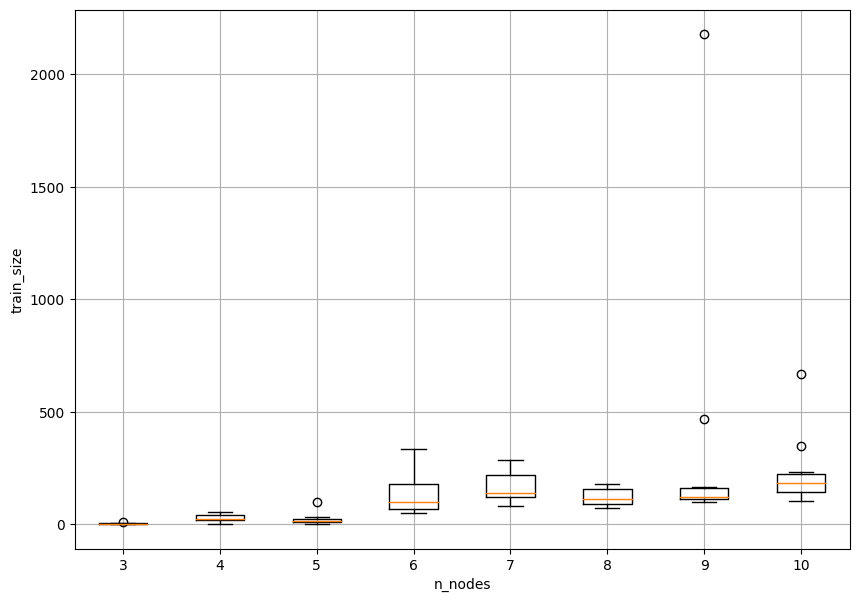

In [50]:
fig = plt.figure(figsize =(10, 7))
ax = fig.add_subplot(111)

box = ax.boxplot(box_data)
ax.set_xticklabels(range(3, 11))
plt.ylabel('train_size')
plt.xlabel('n_nodes')
plt.grid()
plt.show()

In [52]:
import plotly.graph_objects as go

labels = []
for i in range(len(box_data)):
    nodes_label = f"nodes={i+3}"
    if i > 0:
        shd_label = f"shd<={i}"
    else:
        shd_label = f"shd={i}"
    labels.append(f"{nodes_label}<br>{shd_label}")

fig = go.Figure()
for i in range(len(box_data)):
    fig.add_trace(go.Box(y=box_data[i], name=labels[i], showlegend=False))

fig.update_layout(
    title={
        'text': 'Structure learning',
        'y': 0.9,
        'x': 0.46,
        'xanchor': 'center',
        'yanchor': 'top'
    },
    yaxis_title="train_size",
    xaxis=dict(
        tickmode='array',
        tickvals=list(range(len(labels))),
        ticktext=labels
    ),
    width=1000,
    height=600,
    font=dict(
        size=18,
        color="RebeccaPurple"
    )
)

fig.show()


In [54]:
nodes_3 = [5500, 30000, 10000, 32000, 5000, 5200, 10000, 5000, 3500, 5500]
nodes_4 = [5000, 5000, 5300, 7500, 10000, 4000, 10000, 33000]
nodes_5 = [35000, 15000, 5000, 7500, 7500]
nodes_6 = [5000, 15000, 8000, 7500, 15000, 10000, 5000]
nodes_7 = [7500, 7500, 10000, 7500, 6000, ]
nodes_8 = [5000, 5000, 10000]
nodes_9 = [7500, 10000]
nodes_10 = [15000, 10000, 20000]

In [55]:
box_data = [nodes_3, nodes_4, nodes_5, nodes_6, nodes_7, nodes_8, nodes_9, nodes_10]

In [58]:
import plotly.graph_objects as go

labels = []
for i in range(len(box_data)):
    nodes_label = f"nodes={i+3}"
    labels.append(f"{nodes_label}")

fig = go.Figure()
for i in range(len(box_data)):
    fig.add_trace(go.Box(y=box_data[i], name=labels[i], showlegend=False))

fig.update_layout(
    title={
        'text': 'Structure and parameter learning',
        'y': 0.9,
        'x': 0.46,
        'xanchor': 'center',
        'yanchor': 'top'
    },
    yaxis_title="train_size",
    xaxis=dict(
        tickmode='array',
        tickvals=list(range(len(labels))),
        ticktext=labels
    ),
    width=1000,
    height=600,
    font=dict(
        size=18,
        color="RebeccaPurple"
    )
)

fig.show()
